# 0. 데이터 불러오기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/mnt')

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
np.random.seed(1)
plt.rc('font', family='NanumBarunGothic')

pd.options.display.float_format = '{:.5f}'.format

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
interaction = pd.read_csv("/content/mnt/MyDrive/LDA/data/interaction.csv")
lpay = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_06_LPAY.csv")

In [ ]:
interaction.drop(columns = ["vst_dt"], inplace = True)

#2. 가격 예측 모델



## A. Data Preprocessing

### 1) 가격 이상치 확인

#### 상품별 가격 평균, 표준편차 확인

- pdde 데이터에 `buy_ct != 0인 상품`이 존재
- pd_c 별로 정확한 price_mean, price_std를 구한다. 

In [ ]:
# 상품별 buy_ct = 1 가격 : buy_am_only
interaction['buy_am_only']=interaction['buy_am']/interaction['buy_ct']

In [ ]:
# key column 생성
interaction['buy_am_only']=interaction['buy_am_only'].apply(str)
interaction['buy_ct']=interaction['buy_ct'].apply(str)

interaction['key']=interaction['buy_ct']+'-'+interaction['buy_am_only']

interaction['buy_am_only']=interaction['buy_am_only'].apply(float)
interaction['buy_ct']=interaction['buy_ct'].apply(float)
interaction['buy_ct']=interaction['buy_ct'].apply(int)

# pd_price dataframe 생성
pd_price=interaction.groupby(['pd_nm']).key.apply(list).reset_index()
interaction.drop('key',axis=1,inplace=True)
key_data=pd_price.key.values.tolist()

# key column 확인
display(pd_price.head())

,pd_nm,key
0,2단우산,"[1.0-36000.0, 1.0-36000.0, 1.0-55000.0, 1.0-45..."
1,3단우산,"[1.0-10000.0, 1.0-40000.0, 4.0-30000.0, 1.0-45..."
2,B01,"[1.0-60000.0, 1.0-17100.0, 1.0-136500.0, 1.0-3..."
3,BB/파운데이션/컴팩트류,"[1.0-80000.0, 1.0-66000.0, 1.0-69000.0, 1.0-64..."
4,C01,"[1.0-5000.0, 1.0-5000.0, 1.0-5000.0, 1.0-5000...."


In [ ]:
# 상품별 가격 리스트 생성

def make_pd_price_list(data):
  
  '''
  buy_am list 생성
  - key 분리 'buy_ct','buy_am'
  - buy_am list append
  '''

  pd_c_price=[]
  for price_list in data:
    item_price=[]
    for key in price_list:
      split_num=key.index('-')
      buy_ct=int(float((key[:split_num])))
      price=float(key[split_num+1:])
      for i in range(buy_ct):
        item_price.append(price)
    pd_c_price.append(item_price)
  return pd_c_price

#함수 실행
pd_only_price=make_pd_price_list(key_data)

# pd_price dataframe에 넣기
pd_price['pd_only_price']=pd_only_price
pd_price['std']=pd_price['pd_only_price'].apply(np.std)
pd_price['mean']=pd_price['pd_only_price'].apply(np.mean)
pd_price.drop('key',axis=1,inplace=True)

In [ ]:
pd_price.head()

,pd_nm,pd_only_price,std,mean
0,2단우산,"[36000.0, 36000.0, 55000.0, 45000.0, 10000.0, ...",10470.47889,15105.76923
1,3단우산,"[10000.0, 40000.0, 30000.0, 30000.0, 30000.0, ...",497252.61772,78409.82156
2,B01,"[60000.0, 17100.0, 136500.0, 34200.0, 180000.0...",1263259.75065,236895.46912
3,BB/파운데이션/컴팩트류,"[80000.0, 66000.0, 69000.0, 64000.0, 60000.0, ...",99345.11053,66251.48996
4,C01,"[5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000....",9987.05363,11616.86874


#### 가격 평균 상위 60개 상품 시각화

In [ ]:
# mean 순 상위 60개 상품 목록
mean_outlier_idx=pd_price.sort_values('mean',ascending=False).index.tolist()[:60]
outlier_60_mean=pd_price.loc[mean_outlier_idx,['pd_nm','pd_only_price']].reset_index(drop=True)
display(outlier_60_mean.pd_nm.values,
        outlier_60_mean.head())

array(['그림/인테리어렌탈', '시계세트', '남성시계', '핸드폰충전', '기타TV', 'UHD', '금고',
       '양문형냉장고', '안마의자', '드럼세탁기', '멀티형에어컨', '여성코스튬', '냉장/냉동가전소모품',
       '스탠드형김치냉장고', '기타냉장고', '소파', 'LED', '스탠드형에어컨', '여성가방액세서리', '보석세트',
       '침대', '건조기', '일반형냉장고', '물리치료/의료기용품', '일반세탁기', '안마의자/헬스/이미용렌탈',
       '사무용/학생용가구세트', '냉동고', '식기세척기', '여성기타모피의류', '기타에어컨', '노트북', '여성토트백',
       '뚜껑형김치냉장고', '여성숄더백', '온풍기', '매트리스', '식탁세트', '반지', '에어워셔', '가방세트',
       '공기청정기', '침실가구세트', '기타난방가전', '일반청소기', '정수기', '남성숄더/크로스백', '기타청소기',
       '특판', '콤포넌트', '기타보석류', '의류스타일러', '유아동스포츠화부속품', '전자악기', '휴대폰',
       '여성시계', '태블릿PC', '가발/부분가발', '헤어롤', '인덕션/가스레인지'], dtype=object)

,pd_nm,pd_only_price
0,그림/인테리어렌탈,"[1000000.0, 20000000.0, 4000000.0]"
1,시계세트,"[4260000.0, 5200000.0, 2300000.0, 32000.0, 132..."
2,남성시계,"[115000.0, 1513000.0, 481000.0, 1261000.0, 123..."
3,핸드폰충전,[3605000.0]
4,기타TV,"[3192000.0, 2836000.0, 6281000.0, 5874000.0, 5..."


In [ ]:
def get_log(x):

  '''
  log column 생성
  - 가격 리스트 입력
  - log 가격 리스트 반환
  '''

  price_list=[]
  for i in x:
    price=np.log1p(i)
    price_list.append(price)
  return price_list

In [ ]:
outlier_60_mean['log_price']=outlier_60_mean['pd_only_price'].apply(get_log)
outlier_60_mean.head()

,pd_nm,pd_only_price,log_price
0,그림/인테리어렌탈,"[1000000.0, 20000000.0, 4000000.0]","[13.815511557963774, 16.811242881518265, 15.20..."
1,시계세트,"[4260000.0, 5200000.0, 2300000.0, 32000.0, 132...","[15.26477995298731, 15.46416937585933, 14.6484..."
2,남성시계,"[115000.0, 1513000.0, 481000.0, 1261000.0, 123...","[11.652696102959753, 14.229605653708807, 13.08..."
3,핸드폰충전,[3605000.0],[15.09783260609366]
4,기타TV,"[3192000.0, 2836000.0, 6281000.0, 5874000.0, 5...","[14.976158550834995, 14.857905519243403, 15.65..."


- pd_only_price : log 변환 전

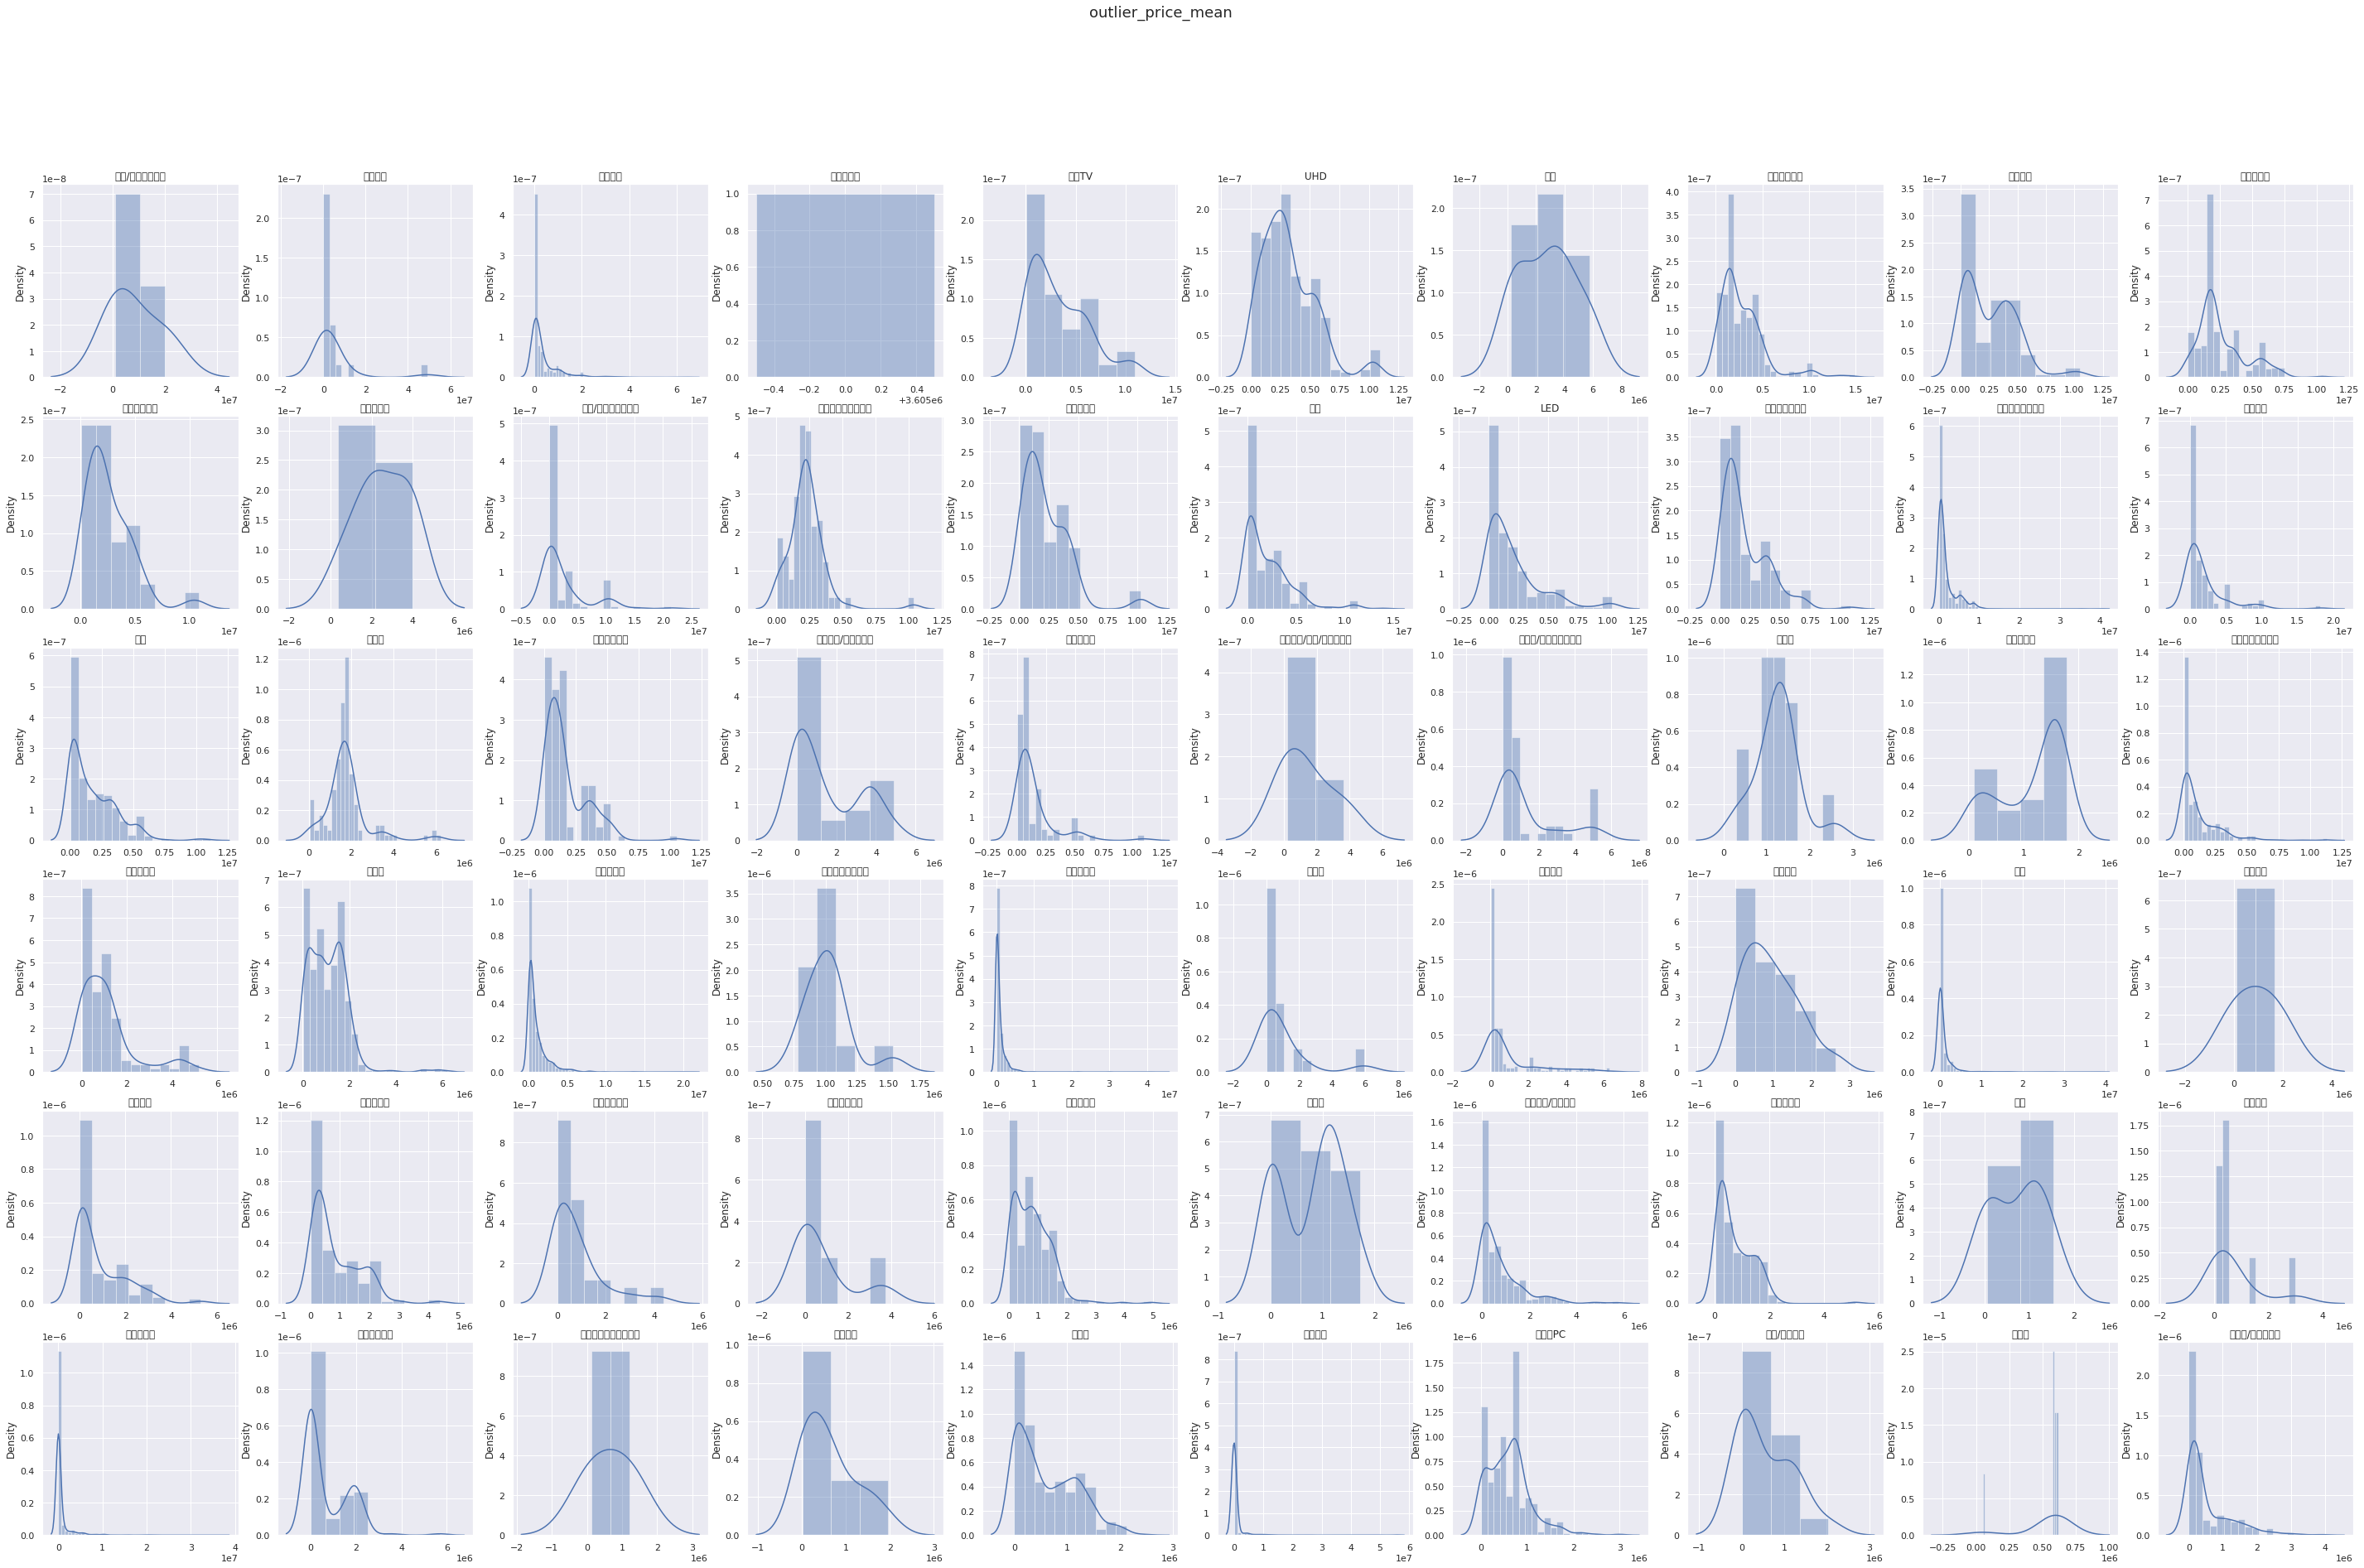

In [ ]:
fig, axs = plt.subplots(6, 10, figsize = (50, 30))
fig.suptitle("outlier_price_mean", fontsize = "18")

for idx, name in enumerate(outlier_60_mean['pd_nm']):
  ax = axs[idx // 10][idx % 10]
  temp = outlier_60_mean.loc[outlier_60_mean.pd_nm==name]['pd_only_price'].values.tolist()[0]
  sns.distplot(temp,ax=ax)
  ax.set_title(f'{name}')

- log_price : log 변환 후

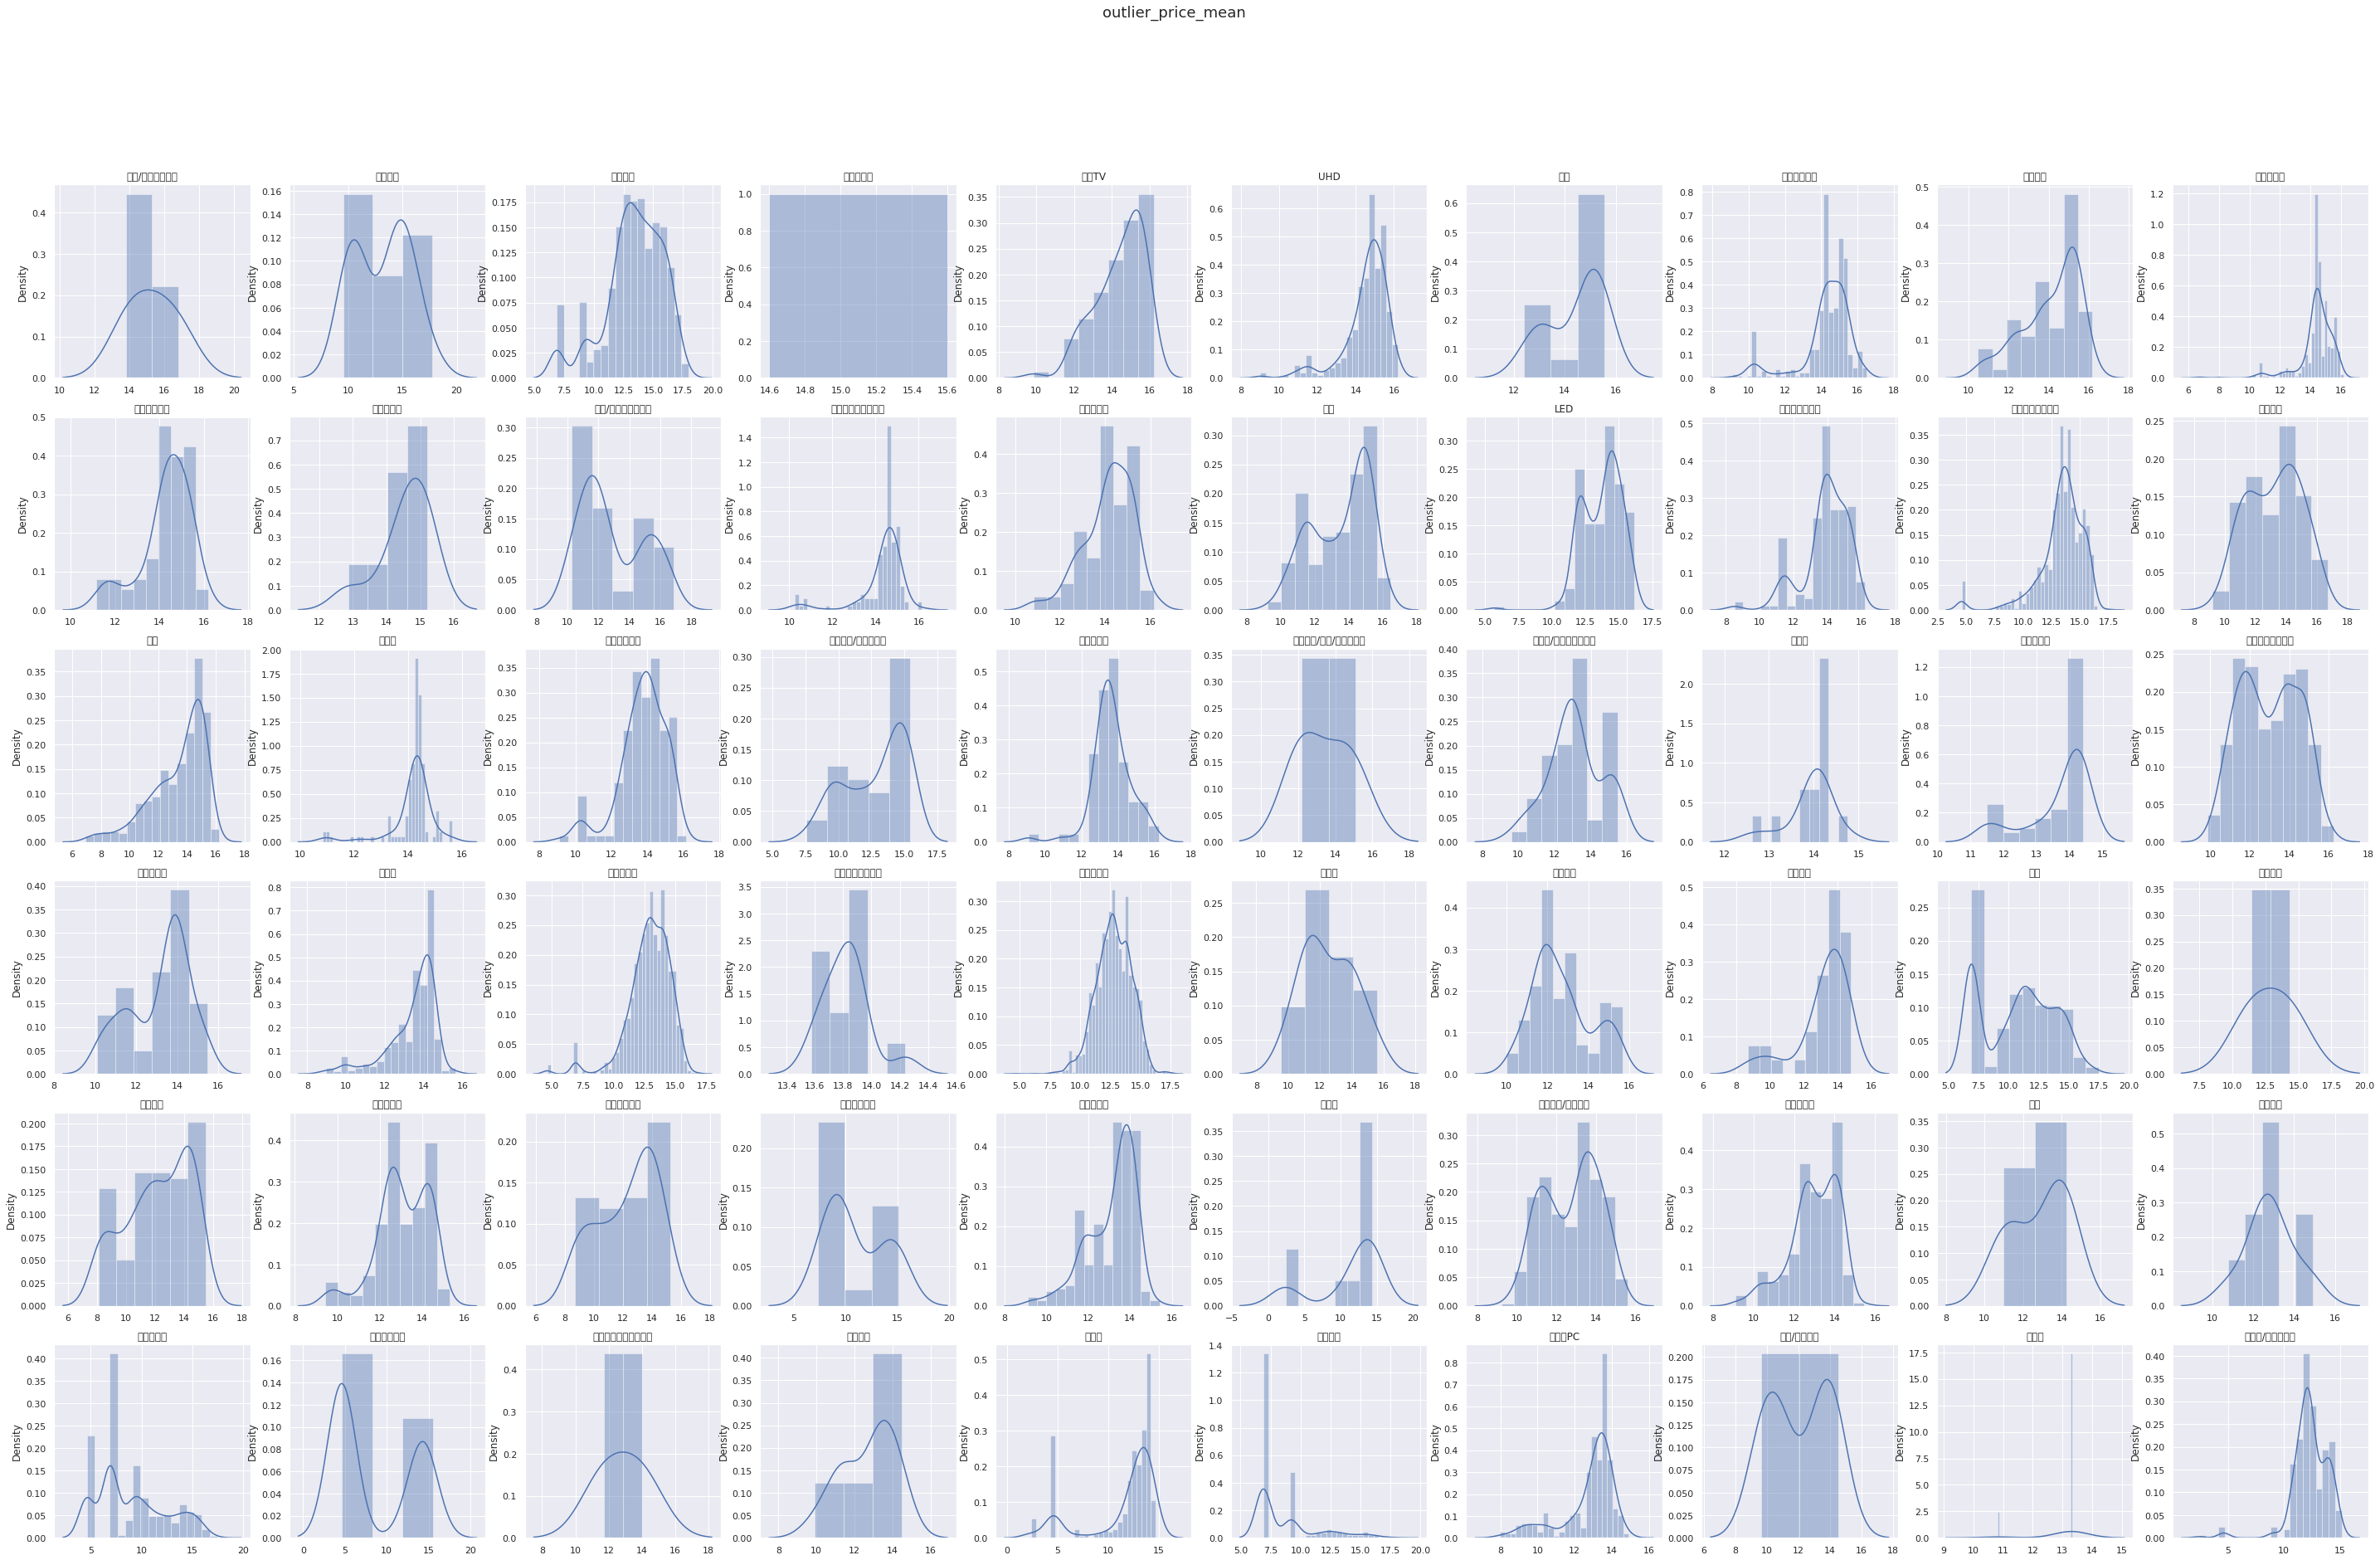

In [ ]:
fig, axs = plt.subplots(6, 10, figsize = (50, 30))
fig.suptitle("outlier_price_mean", fontsize = "18")

for idx, name in enumerate(outlier_60_mean['pd_nm']):
  ax = axs[idx // 10][idx % 10]
  temp = outlier_60_mean.loc[outlier_60_mean.pd_nm==name]['log_price'].values.tolist()[0]
  sns.distplot(temp,ax=ax)
  ax.set_title(f'{name}')

#### 가격 표준편차 상위 60개 상품 시각화

In [ ]:
# std 순 상위 60개 상품 목록
std_outlier_idx=pd_price.sort_values('std',ascending=False).index.tolist()[:60]
outlier_60=pd_price.loc[std_outlier_idx,['pd_nm','pd_only_price']].reset_index(drop=True)
display(outlier_60.pd_nm.values,
        outlier_60.head())

array(['시계세트', '그림/인테리어렌탈', '남성시계', '냉장/냉동가전소모품', '여성시계', '반지', '기타TV',
       '보석세트', '여성가방액세서리', '양문형냉장고', '소파', '기타보석류', 'LED', '안마의자', 'UHD',
       '멀티형에어컨', '여성숄더백', '기타냉장고', '금고', '드럼세탁기', '스탠드형에어컨', '침대',
       '일반세탁기', '팔찌', '사무용/학생용가구세트', '물리치료/의료기용품', '일반형냉장고', '여성기타모피의류',
       '온풍기', '여성토트백', '매트리스', '스탠드형김치냉장고', '안마의자/헬스/이미용렌탈', '기타패션잡화',
       '기타난방가전', 'B01', '기타주방가전', '여성코스튬', '기타에어컨', '웨이트기구', '가방세트',
       '침실가구세트', '여성밍크의류', '목걸이', '유아동옷장', '기타가구', '한우선물세트', '시계부속품',
       '건조기', '의류스타일러', '골프채', '남성숄더/크로스백', '유아패션잡화', '콤포넌트', '골프공',
       '노트북', '화장대', '공기청정기', '남성골프바지', '에어워셔'], dtype=object)

,pd_nm,pd_only_price
0,시계세트,"[4260000.0, 5200000.0, 2300000.0, 32000.0, 132..."
1,그림/인테리어렌탈,"[1000000.0, 20000000.0, 4000000.0]"
2,남성시계,"[115000.0, 1513000.0, 481000.0, 1261000.0, 123..."
3,냉장/냉동가전소모품,"[10430000.0, 10420000.0, 21409000.0, 10310000...."
4,여성시계,"[175000.0, 330000.0, 496000.0, 39900.0, 588000..."


In [ ]:
outlier_60['log_price']=outlier_60['pd_only_price'].apply(get_log)
outlier_60.head()

,pd_nm,pd_only_price,log_price
0,시계세트,"[4260000.0, 5200000.0, 2300000.0, 32000.0, 132...","[15.26477995298731, 15.46416937585933, 14.6484..."
1,그림/인테리어렌탈,"[1000000.0, 20000000.0, 4000000.0]","[13.815511557963774, 16.811242881518265, 15.20..."
2,남성시계,"[115000.0, 1513000.0, 481000.0, 1261000.0, 123...","[11.652696102959753, 14.229605653708807, 13.08..."
3,냉장/냉동가전소모품,"[10430000.0, 10420000.0, 21409000.0, 10310000....","[16.160196922854226, 16.15923769025878, 16.879..."
4,여성시계,"[175000.0, 330000.0, 496000.0, 39900.0, 588000...","[12.07254696717504, 12.706850963741102, 13.114..."


- pd_only_price : log 변환 전

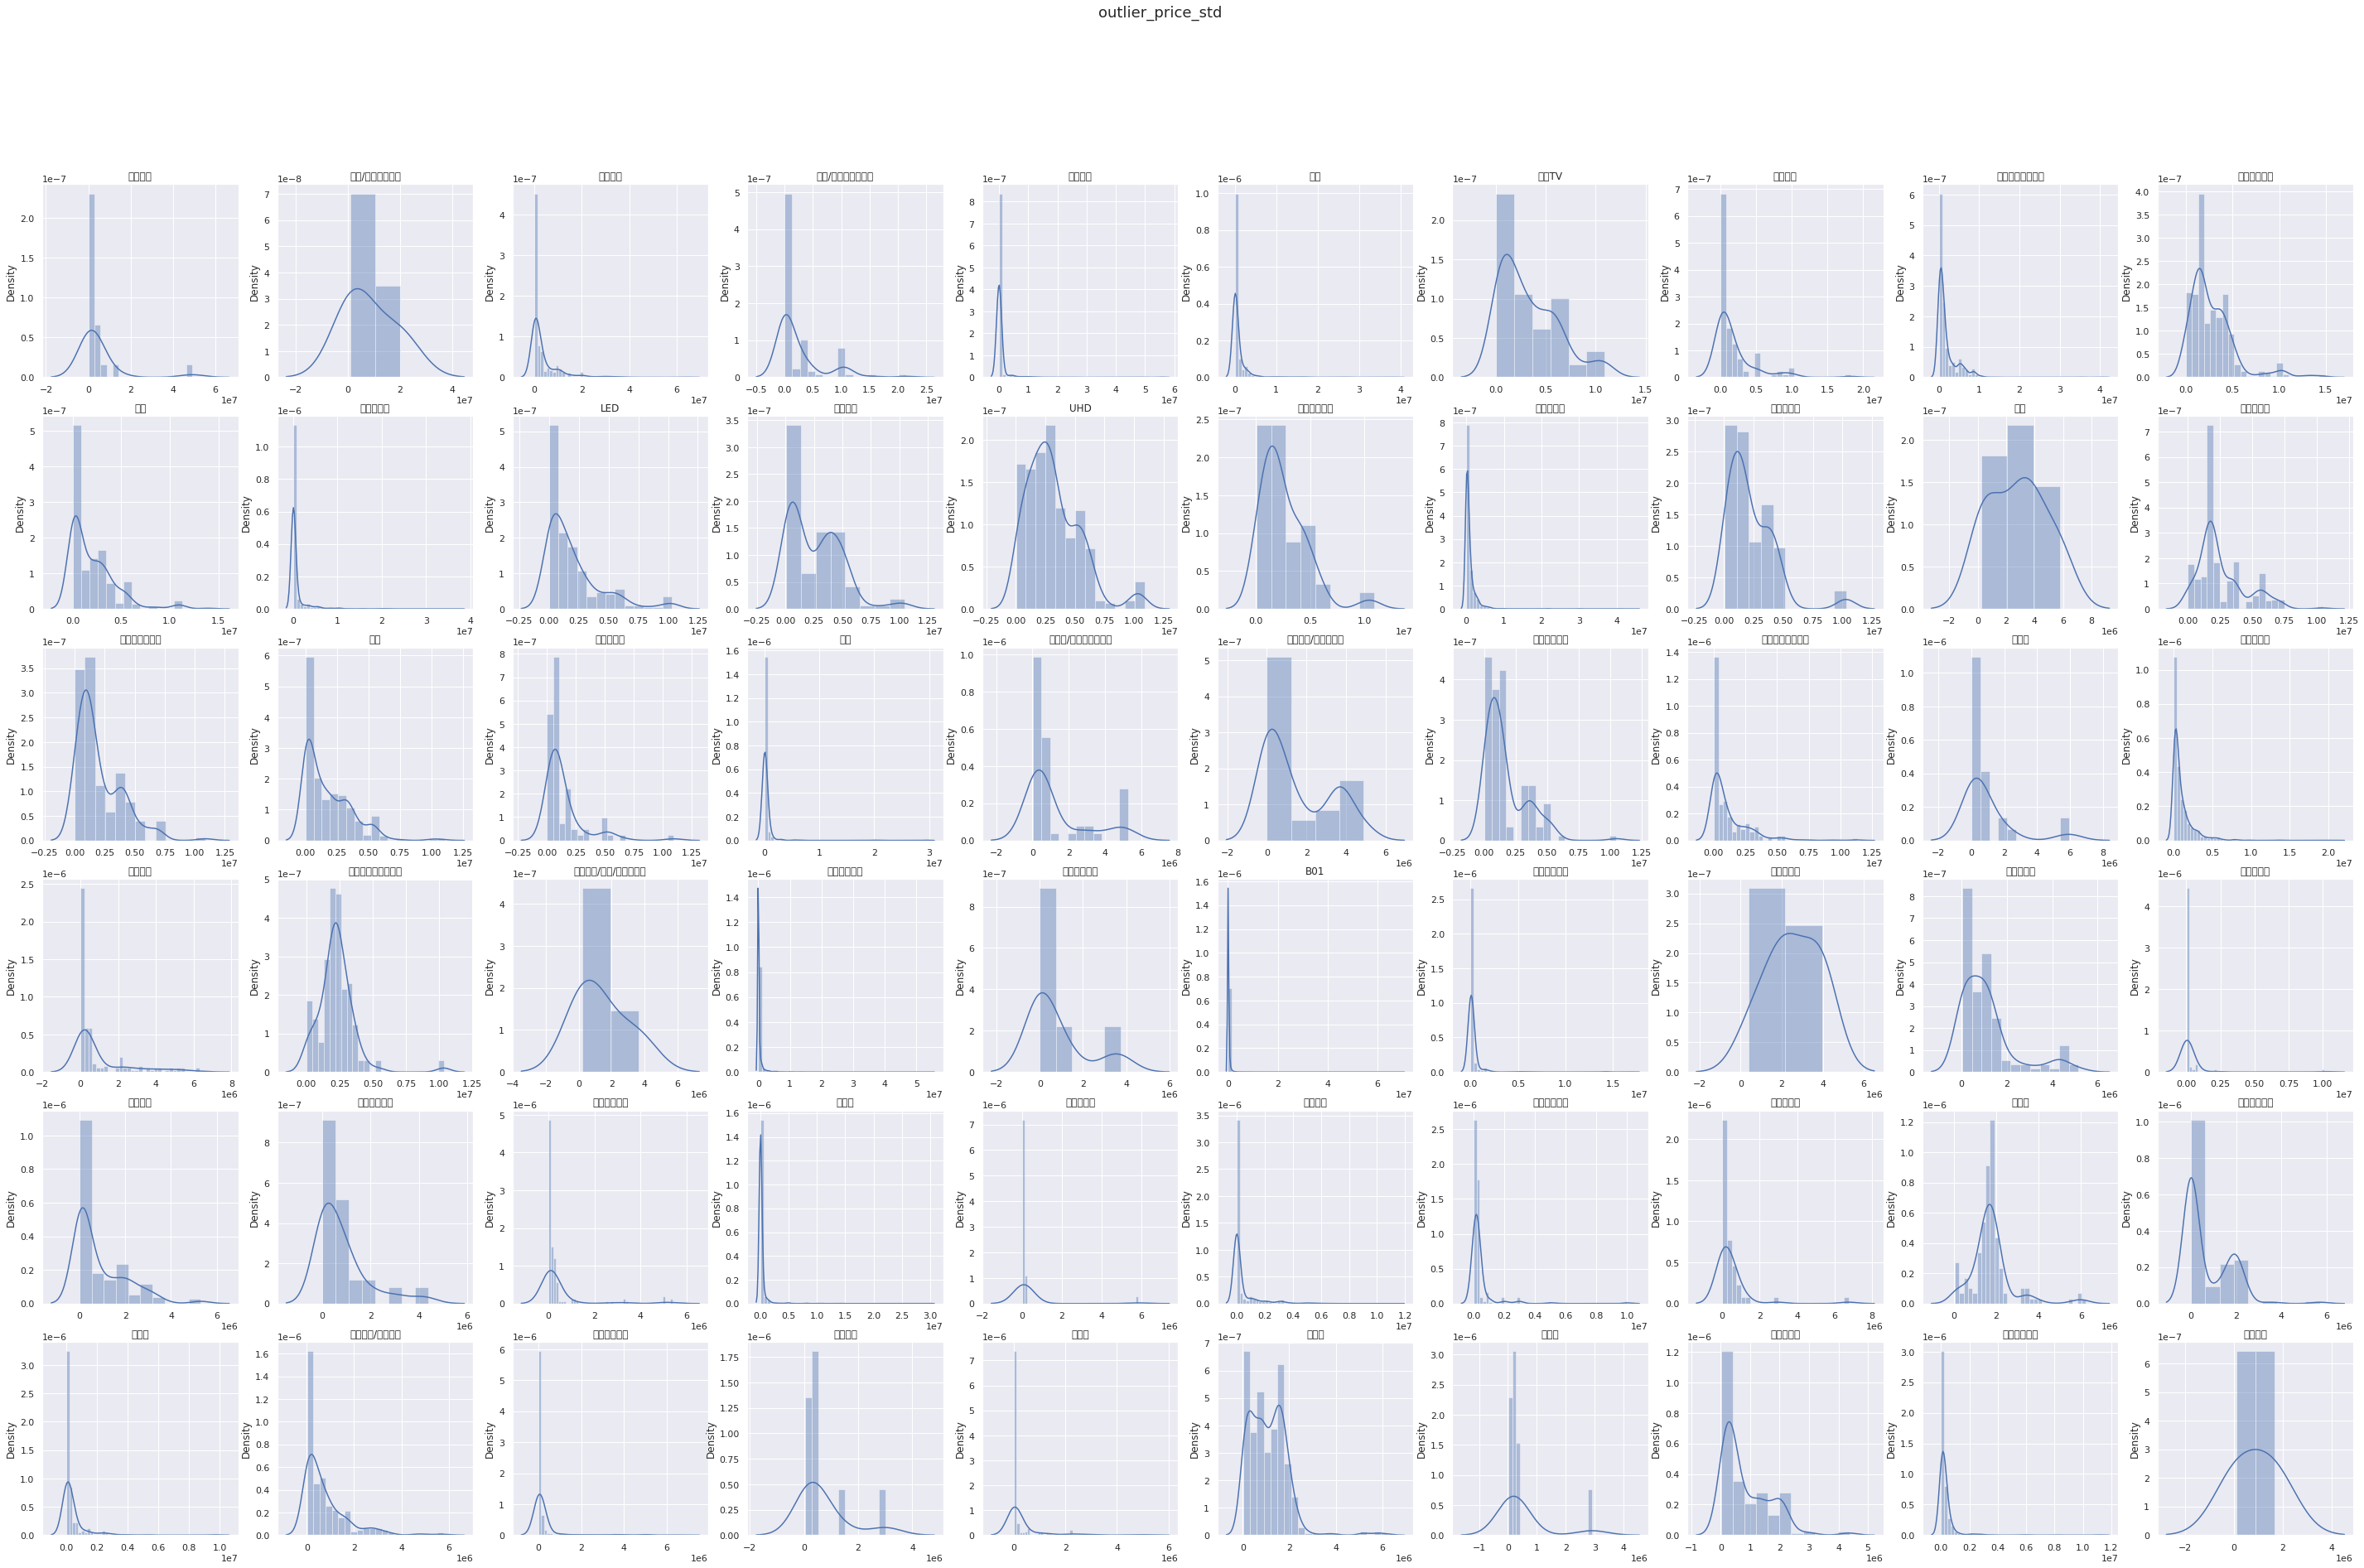

In [ ]:
fig, axs = plt.subplots(6, 10, figsize = (50, 30))
fig.suptitle("outlier_price_std", fontsize = "18")

for idx, name in enumerate(outlier_60['pd_nm']):
  ax = axs[idx // 10][idx % 10]
  temp = outlier_60.loc[outlier_60.pd_nm==name]['pd_only_price'].values.tolist()[0]
  sns.distplot(temp,ax=ax)
  ax.set_title(f'{name}')

- log_price : log 변환 후

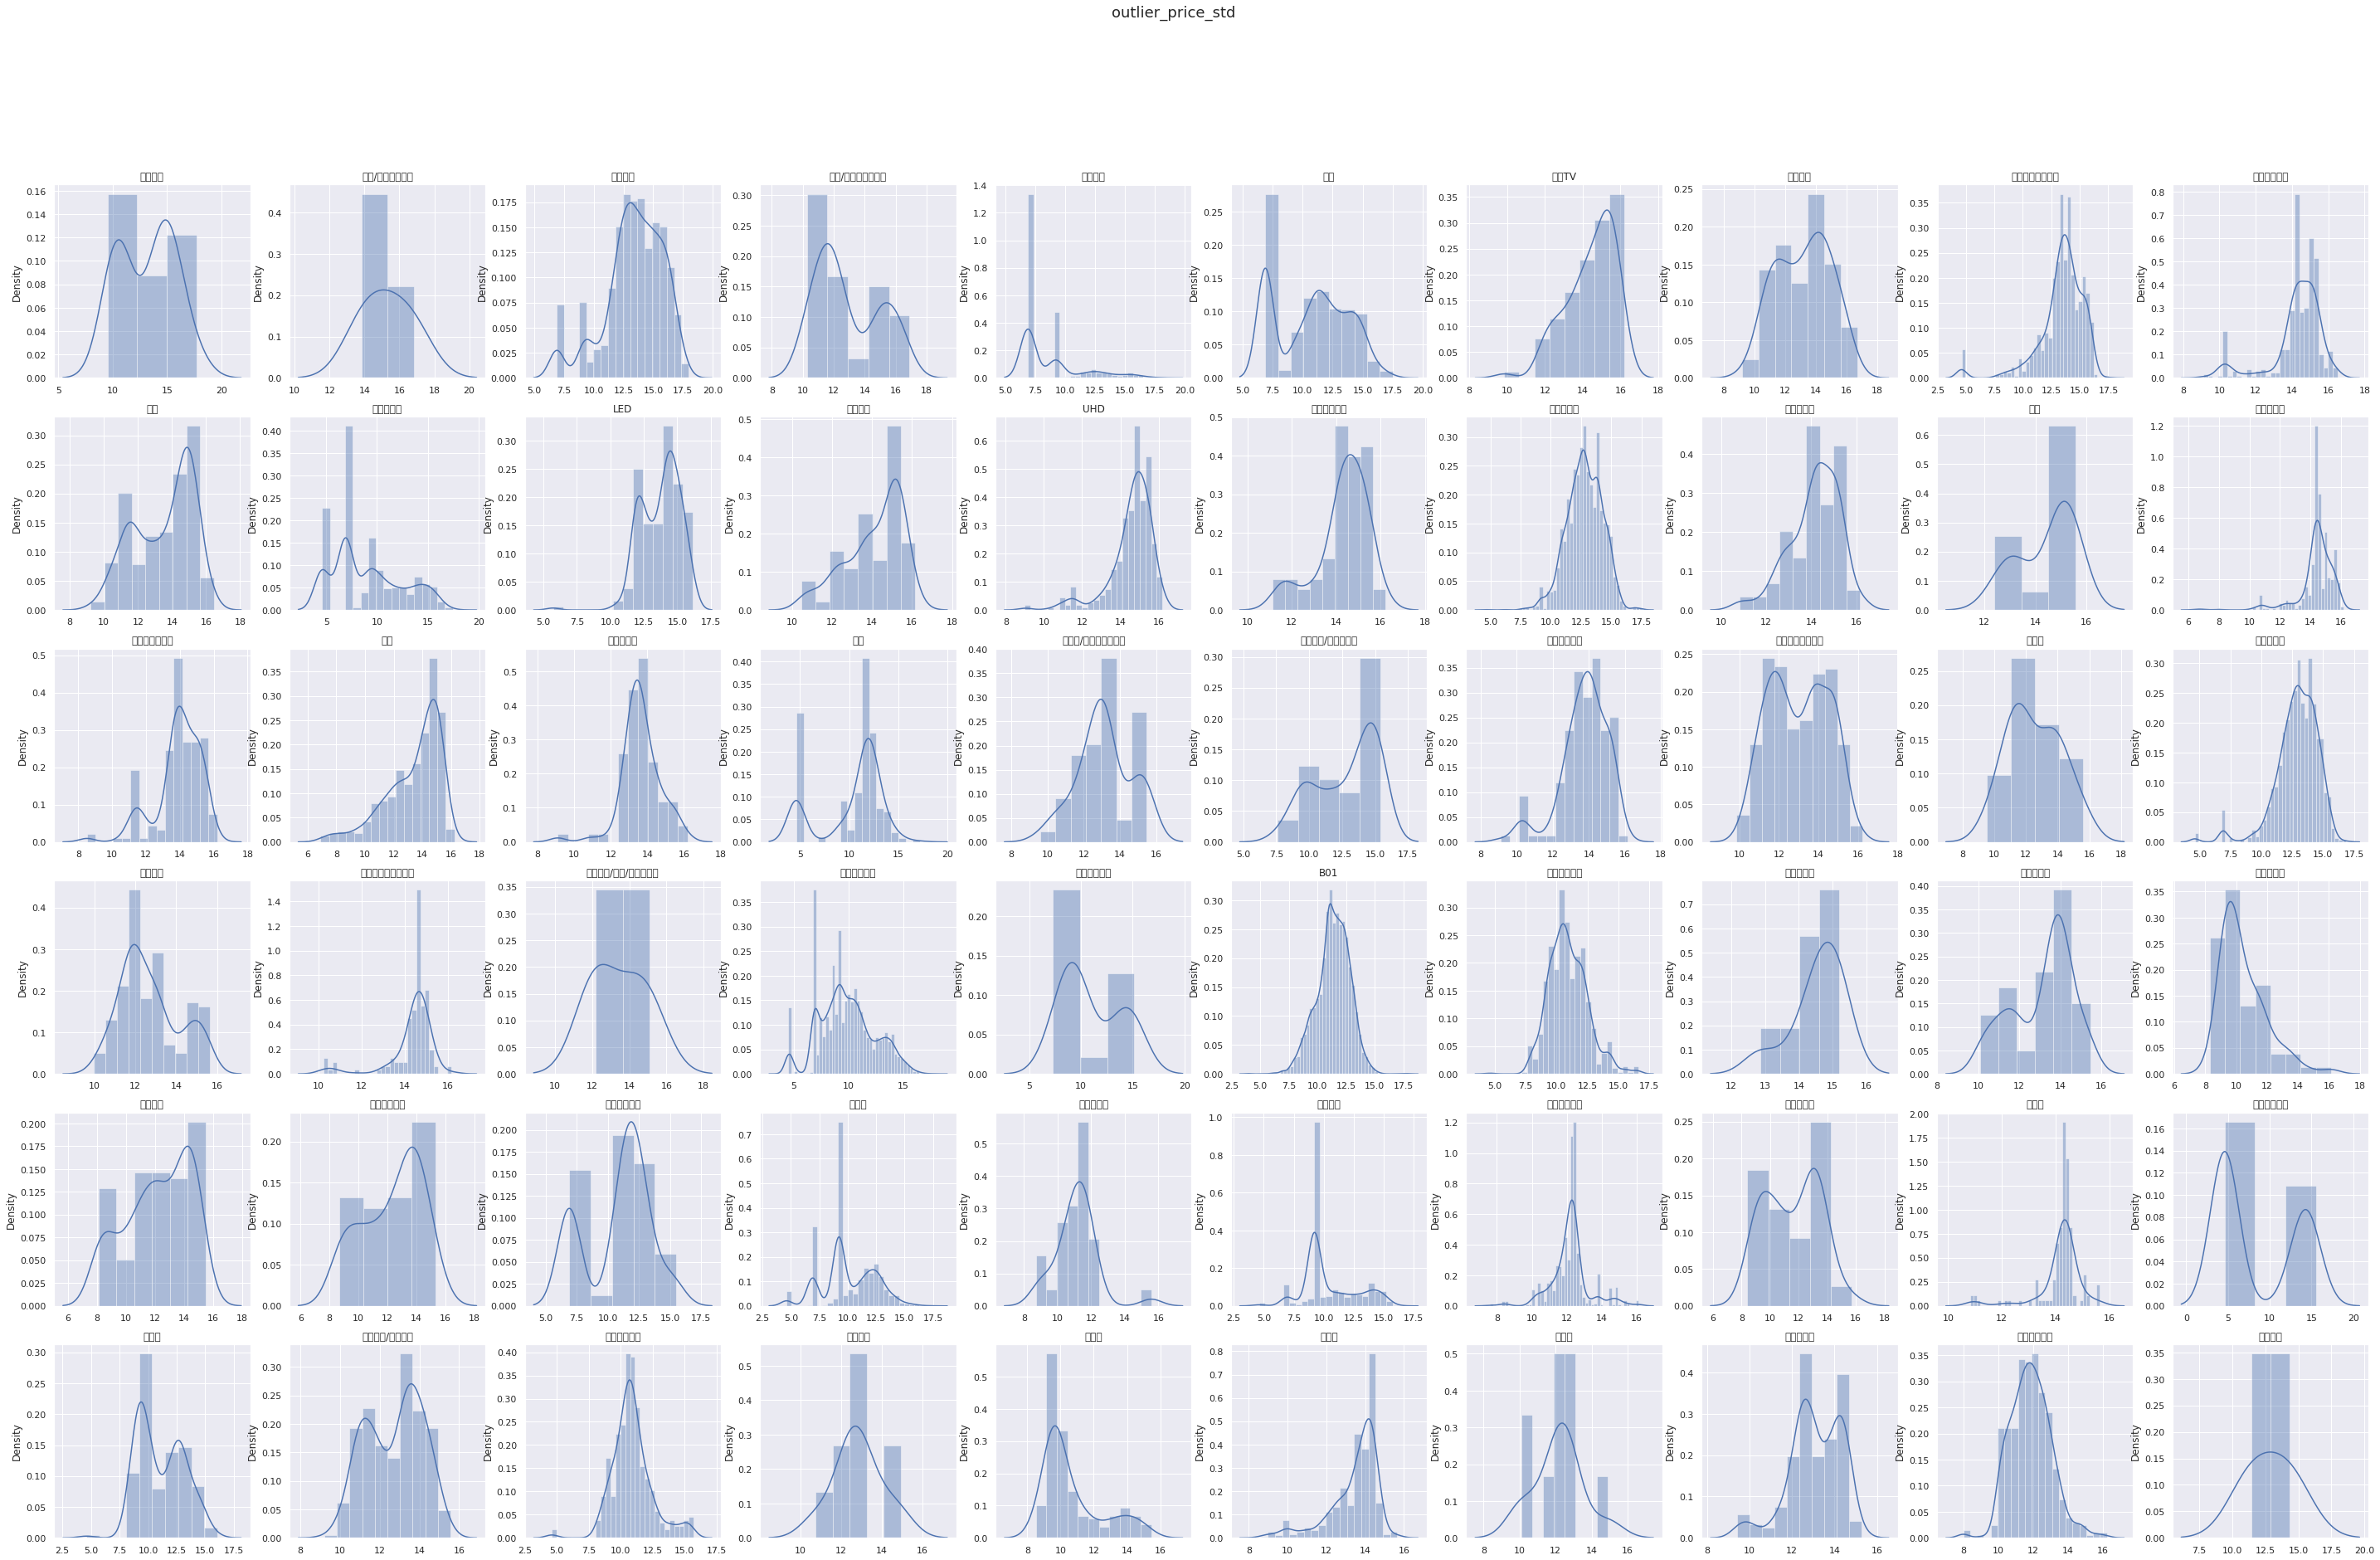

In [ ]:
fig, axs = plt.subplots(6, 10, figsize = (50, 30))
fig.suptitle("outlier_price_std", fontsize = "18")

for idx, name in enumerate(outlier_60['pd_nm']):
  ax = axs[idx // 10][idx % 10]
  temp = outlier_60.loc[outlier_60.pd_nm==name]['log_price'].values.tolist()[0]
  sns.distplot(temp,ax=ax)
  ax.set_title(f'{name}')

### 2) 가격 이상치 보정
- `minimum price = 5% of 전체 log_price`
- `maximum price = 95% of 전체 log_price`

#### 상품별 상한, 하한 가격 추출
- limit_price_dict
- key : pd_c
- value 0 : low_limit, value 1 : up_limit

In [ ]:
# log_price column 생성
pd_price['log_price']=pd_price['pd_only_price'].apply(get_log)
interaction['log_price']=interaction['buy_am_only'].apply(np.log1p)
display(pd_price.head(),
        interaction.head())

,pd_nm,pd_only_price,std,mean,log_price
0,2단우산,"[36000.0, 36000.0, 55000.0, 45000.0, 10000.0, ...",10470.47889,15105.76923,"[10.491301994830229, 10.491301994830229, 10.91..."
1,3단우산,"[10000.0, 40000.0, 30000.0, 30000.0, 30000.0, ...",497252.61772,78409.82156,"[9.210440366976517, 10.596659732783579, 10.308..."
2,B01,"[60000.0, 17100.0, 136500.0, 34200.0, 180000.0...",1263259.75065,236895.46912,"[11.002116507732017, 9.746892220313054, 11.824..."
3,BB/파운데이션/컴팩트류,"[80000.0, 66000.0, 69000.0, 64000.0, 60000.0, ...",99345.11053,66251.48996,"[11.289794413577894, 11.097425172408931, 11.14..."
4,C01,"[5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000....",9987.05363,11616.86874,"[8.517393171418904, 8.517393171418904, 8.51739..."


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,ma_fem_dv,ages,zon_hlv_user,zon_hlv,zon_mcls,pd_nm,clac_mcls_nm,clac_hlv_nm,buy_am_only,log_price
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.00000,1,...,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,15000.00000,9.61587
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.00000,1,...,여성,40대,Z13,Z13,Z13001,기타주방일회용품,주방일회용품,주방잡화,79700.00000,11.28604
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.00000,1,...,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.00000,1,...,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.00000,1,...,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225


In [ ]:
#limit_price_dict 생성
def get_outlier_limit(data):

  '''
  가격 상한, 하한 dict 생성

  - 상품명, 상품 가격 리스트 입력
  - key : pd_nm, value : low_limit, up_limit
  - up_limit : 상품 가격의 상위 5%
  - low_limit : 상품 가격의 상위 95%
  '''

  pd_c_list=data.pd_nm.values.tolist()
  columns_iqr={}

  for i in pd_c_list:
    price_list=data.loc[data.pd_nm==i].log_price.values[0]

    quartile1 = np.quantile(price_list, 0.05)
    quartile3 = np.quantile(price_list, 0.95)             

    low_limit = quartile1
    up_limit = quartile3

    columns_iqr[i]=[low_limit, up_limit]
    
  return columns_iqr

limit_price_dict=get_outlier_limit(pd_price)
limit_price_dict

{'2단우산': [9.210440366976517, 10.591714092984121],
 '3단우산': [8.853808274977197, 10.900290411632819],
 'B01': [8.803889767277028, 13.52207815684787],
 'BB/파운데이션/컴팩트류': [8.006700845440367, 11.849404844423074],
 'C01': [6.90875477931522, 10.239995502805316],
 'C02': [8.006700845440367, 10.896757843893464],
 'CDP/카세트': [10.725567700759076, 11.651876714433401],
 'D01': [7.550135342488429, 10.094149233605084],
 'D02': [8.006700845440367, 9.985113621416073],
 'DIY가구': [7.313886831633462, 11.250639584734841],
 'DIY완구': [7.601402334583733, 10.594156665220533],
 'DSLR': [9.206923102927616, 13.961921870348405],
 'DVD플레이어': [9.51406447650803, 11.297332442074728],
 'E01': [6.837331090279973, 12.194380542188807],
 'L00': [4.61512051684126, 12.275468882547738],
 'L01': [6.90875477931522, 11.969723533345908],
 'L02': [8.071218539969863, 12.853544846204807],
 'L03': [7.635786861395585, 11.703413582688565],
 'L04': [7.244941546337007, 10.91967791392814],
 'L05': [6.90875477931522, 9.842143909572997],
 'L

#### 가격 이상치 대체

In [ ]:
# key column 만들기
interaction['log_price']=interaction['log_price'].apply(str)
interaction['key']=interaction['pd_nm']+'-'+interaction['log_price']
interaction['log_price']=interaction['log_price'].apply(float)

In [ ]:
# 가격 이상치 상한, 하한 가격으로 대체
def replace_outlier_limit(x):

  '''
  가격 이상치 보정

  '''
  split_num=x.index('-')
  key=x[:split_num]
  price=float(x[split_num+1:])

  low_limit=limit_price_dict[key][0]
  up_limit=limit_price_dict[key][1]

  if (price < low_limit):
    return low_limit
  elif (price > up_limit):
    return up_limit
  else:
    return price

interaction['cor_price']=interaction['key'].apply(replace_outlier_limit)

In [ ]:
#가격 보정 전 후 비교
interaction.loc[interaction.log_price!=interaction.cor_price].head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,zon_hlv_user,zon_hlv,zon_mcls,pd_nm,clac_mcls_nm,clac_hlv_nm,buy_am_only,log_price,key,cor_price
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.00000,1,...,Z13,Z13,Z13001,기타주방일회용품,주방일회용품,주방잡화,79700.00000,11.28604,기타주방일회용품-11.286037411751035,11.13577
7,M430112881,A01000007648,1,A01,A010039,PD0252,20210101,11,49000.00000,1,...,Z17,Z10,Z10042,기타구기/필드스포츠용품,기타구기/필드스포츠,구기/필드스포츠,49000.00000,10.79960,기타구기/필드스포츠용품-10.799595985047786,10.57134
15,M117855953,A01000014211,1,A01,A010049,PD0949,20210101,11,759500.00000,1,...,Z11,Z11,Z11012,여성티셔츠/탑,여성의류상의,여성의류,759500.00000,13.54042,여성티셔츠/탑-13.540416917672792,11.92637
23,M860973355,A01000021318,1,A01,A010039,PD1081,20210101,11,279000.00000,1,...,Z10,Z10,Z10042,남아티셔츠/탑,남아의류상의,유아동의류,279000.00000,12.53897,남아티셔츠/탑-12.53897064502647,12.39339
26,M625839441,A01000024552,1,A01,A010045,PD0787,20210101,12,487000.00000,1,...,Z16,Z16,Z16003,남성트레이닝복,남성일반스포츠의류,스포츠패션,487000.00000,13.09602,남성트레이닝복-13.096021455450709,12.25009


In [ ]:
# 가격 보정 전 column 삭제
interaction.drop(['buy_am','buy_am_only','log_price','key'],axis=1,inplace=True)

# 가격 보정 후 column 추가
interaction['buy_am']=interaction['cor_price'].apply(np.expm1)
interaction['buy_am']=interaction['buy_ct']*interaction['buy_am'] # buy_ct 반영
interaction['buy_am_log']=interaction['buy_am'].apply(np.log1p)
interaction.drop('cor_price',axis=1,inplace=True)
interaction.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,ma_fem_dv,ages,zon_hlv_user,zon_hlv,zon_mcls,pd_nm,clac_mcls_nm,clac_hlv_nm,buy_am,buy_am_log
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,15000.00000,9.61587
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,1,0,여성,40대,Z13,Z13,Z13001,기타주방일회용품,주방일회용품,주방잡화,68579.95334,11.13577
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225


### 3) 데이터 split

- 유저 특성 feature engineering data : `train_interaction` 2021-01-01 ~ 2021-11-14
- 학습 data : `train_data` 2021-11-15 ~ 2021-12-15
- 검증 data : `eval_data` 2021-12-15 ~

In [ ]:
interaction['de_dt']=interaction['de_dt'].astype('str')
interaction['de_dt'] = pd.to_datetime(interaction["de_dt"])

In [ ]:
train_interaction = interaction.loc[interaction.de_dt < "2021-11-15"]
df_interaction = interaction.loc[interaction.de_dt >= "2021-11-15"]

In [ ]:
train_interaction.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,ma_fem_dv,ages,zon_hlv_user,zon_hlv,zon_mcls,pd_nm,clac_mcls_nm,clac_hlv_nm,buy_am,buy_am_log
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,15000.00000,9.61587
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,1,0,여성,40대,Z13,Z13,Z13001,기타주방일회용품,주방일회용품,주방잡화,68579.95334,11.13577
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225


## B. Feature Engineering

### 1) feature 1, 2
- 고객의 상품별 구매 개수 평균 차이

- `feature 1` : (상품별) $$\frac{개별 고객의 구매 가격}{개별 고객의 구매 개수} - \frac{전체 고객의 구매 가격}{전체 고객의 구매 개수}$$

- `feature 2` : (상품별) $$\frac{개별 고객의 구매 개수}{개별 고객의 거래 수} - \frac{전체 고객의 구매 개수}{전체 고객의 구매 수}$$

#### 전체 고객의 평균

- 전체고객의 평균
- buy_am_mean_total : 품목 하나당 평균 buy_am
- buy_ct_mean_total : 거래 한번당 평균 buy_ct

##### 로그 정규화

In [ ]:
# 상품별 전체 고객 buy_ct 합
df_pd_total_1=train_interaction.groupby(['pd_nm']).buy_ct.sum().reset_index()

# 상품별 전체 고객 buy_am 합
df_pd_total_2=train_interaction.groupby(['pd_nm']).buy_am.sum().reset_index()

# 상품별 전체 고객의 거래 수 (rct_no 수)
df_pd_total_3=train_interaction.groupby(['pd_nm']).rct_no.nunique().reset_index()

#병합
df_pd_total=pd.merge(df_pd_total_1,df_pd_total_2,on='pd_nm',how='inner')
df_pd_total=pd.merge(df_pd_total,df_pd_total_3,on='pd_nm',how='inner')

# buy_am_mean_total : buy_ct 하나 당 buy_am 구하기 
df_pd_total['buy_am_mean'] = df_pd_total['buy_am']/df_pd_total['buy_ct']
df_pd_total['buy_am_mean'] = df_pd_total['buy_am_mean'].apply(np.log1p)


# buy_ct_mean_total : 거래 한번 당 buy_ct 수 구하기
df_pd_total['buy_ct_mean']=df_pd_total['buy_ct']/df_pd_total['rct_no']

# drop & rename
df_pd_total.drop(['buy_ct','buy_am','rct_no'],axis=1,inplace=True)
df_pd_total.rename(columns={'buy_am_mean':'buy_am_mean_total','buy_ct_mean':'buy_ct_mean_total'},inplace=True)

In [ ]:
df_pd_total.head()

,pd_nm,buy_am_mean_total,buy_ct_mean_total
0,2단우산,9.57906,1.04000
1,3단우산,9.86369,1.26923
2,B01,12.07858,1.00000
3,BB/파운데이션/컴팩트류,10.95976,1.26289
4,C01,9.31973,1.00000


#### 개별 고객의 평균

- 개별 고객의 평균
- buy_am_mean : 품목 하나당 평균 buy_am
- buy_ct_mean : 거래 한번당 평균 buy_ct

In [ ]:
#상품별 buy_am sum
df_pd_1=train_interaction.groupby(['cust','pd_nm'])[['buy_am']].sum()

#상품별 buy_ct sum
df_pd_2=train_interaction.groupby(['cust','pd_nm'])[['buy_ct']].sum()

#상품별 rct_no count
df_pd_3=train_interaction.groupby(['cust','pd_nm'])[['rct_no']].nunique()

# 병합
df_pd=pd.concat([df_pd_1,df_pd_2,df_pd_3],axis=1,join='inner').reset_index()

# 평균 구하기
df_pd['buy_am_mean']=df_pd['buy_am']/df_pd['buy_ct']
df_pd['buy_ct_mean']=df_pd['buy_ct']/df_pd['rct_no']
df_pd.head()

,cust,pd_nm,buy_am,buy_ct,rct_no,buy_am_mean,buy_ct_mean
0,M000034966,D01,3900.00000,1,1,3900.00000,1.00000
1,M000034966,가공조미료,9360.00000,3,1,3120.00000,3.00000
2,M000034966,간장,8300.00000,1,1,8300.00000,1.00000
3,M000034966,과일음료,1200.00000,1,1,1200.00000,1.00000
4,M000034966,국산맥주,27240.00000,6,2,4540.00000,3.00000



#### 전체 고객 - 개별 고객
- buy_am_mean_diff : buy_am_mean - buy_am_mean_total
- buy_ct_mean_diff : buy_ct_mean - buy_ct_mean_total

In [ ]:
#병합
df_pd=pd.merge(df_pd,df_pd_total,how='inner',on='pd_nm')

#차이 구하기
df_pd['buy_am_mean_diff']=df_pd['buy_am_mean']-df_pd['buy_am_mean_total']
df_pd['buy_ct_mean_diff']=df_pd['buy_ct_mean']-df_pd['buy_ct_mean_total']
df_pd.head()

,cust,pd_nm,buy_am,buy_ct,rct_no,buy_am_mean,buy_ct_mean,buy_am_mean_total,buy_ct_mean_total,buy_am_mean_diff,buy_ct_mean_diff
0,M000034966,D01,3900.00000,1,1,3900.00000,1.00000,9.19027,1.00000,3890.80973,0.00000
1,M000136117,D01,200800.00000,13,13,15446.15385,1.00000,9.19027,1.00000,15436.96358,0.00000
2,M000261625,D01,23250.00000,1,1,23250.00000,1.00000,9.19027,1.00000,23240.80973,0.00000
3,M000419293,D01,105900.00000,8,8,13237.50000,1.00000,9.19027,1.00000,13228.30973,0.00000
4,M000494848,D01,37020.00000,4,4,9255.00000,1.00000,9.19027,1.00000,9245.80973,0.00000


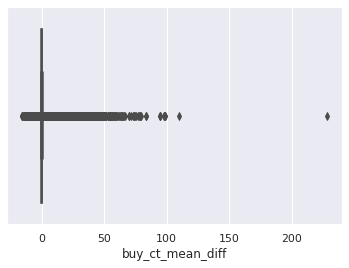

In [ ]:
sns.boxplot(df_pd['buy_ct_mean_diff'])

#### 스케일링 필요

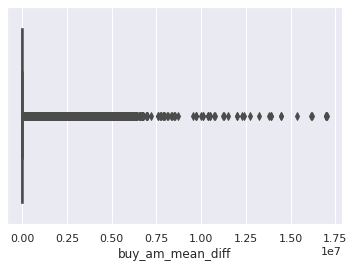

In [ ]:
sns.boxplot(df_pd['buy_am_mean_diff'])

- 음수인 수가 1개 뿐이므로 log scaling 진행

In [ ]:
df_pd.loc[df_pd['buy_am_mean_diff'] < 0]

,cust,pd_nm,buy_am,buy_ct,rct_no,buy_am_mean,buy_ct_mean,buy_am_mean_total,buy_ct_mean_total,buy_am_mean_diff,buy_ct_mean_diff
1544471,M296090374,정수기,80.00000,8,1,10.00000,8.00000,13.47770,1.21212,-3.47770,6.78788


In [ ]:
df_pd['buy_am_mean_diff'] = df_pd['buy_am_mean_diff'].apply(np.log1p)
df_pd.head()

,cust,pd_nm,buy_am,buy_ct,rct_no,buy_am_mean,buy_ct_mean,buy_am_mean_total,buy_ct_mean_total,buy_am_mean_diff,buy_ct_mean_diff
0,M000034966,D01,3900.00000,1,1,3900.00000,1.00000,9.19027,1.00000,8.26663,0.00000
1,M000136117,D01,200800.00000,13,13,15446.15385,1.00000,9.19027,1.00000,9.64458,0.00000
2,M000261625,D01,23250.00000,1,1,23250.00000,1.00000,9.19027,1.00000,10.05371,0.00000
3,M000419293,D01,105900.00000,8,8,13237.50000,1.00000,9.19027,1.00000,9.49019,0.00000
4,M000494848,D01,37020.00000,4,4,9255.00000,1.00000,9.19027,1.00000,9.13203,0.00000


#### feature 입력

In [ ]:
# 병합
df_pd=df_pd[['cust','pd_nm','buy_am_mean_diff','buy_ct_mean_diff']]
train_interaction=pd.merge(train_interaction,df_pd,how='inner',on=['cust','pd_nm'])
train_interaction

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,zon_hlv_user,zon_hlv,zon_mcls,pd_nm,clac_mcls_nm,clac_hlv_nm,buy_am,buy_am_log,buy_am_mean_diff,buy_ct_mean_diff
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,15000.00000,9.61587,9.79759,-0.77066
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225,9.79759,-0.77066
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225,9.79759,-0.77066
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,19000.00000,9.85225,9.79759,-0.77066
4,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,1,0,...,Z13,Z13,Z13001,기타주방일회용품,주방일회용품,주방잡화,68579.95334,11.13577,10.70665,-0.21936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4429702,M688241278,210125110643662,2,A06,A069999,PD1947,2021-01-25,11,1,2,...,Z17,Z18,Z18,L07,A06,유통사,27120.00000,10.20806,10.20767,0.00000
4429703,M220008309,210113130538421,2,A05,A059999,PD1946,2021-01-13,13,1,2,...,Z17,Z18,Z18,L06,A05,유통사,129000.00000,11.76758,11.76748,0.00000
4429704,M470112503,210104210651243,2,A06,A069999,PD1947,2021-01-04,21,1,2,...,Z16,Z18,Z18,L07,A06,유통사,50920.00000,10.83803,10.50169,0.00000
4429705,M470112503,210125110644545,2,A06,A069999,PD1947,2021-01-25,11,1,2,...,Z16,Z18,Z18,L07,A06,유통사,51800.00000,10.85516,10.50169,0.00000


### 2) feature 3, 4, 5

- 고객의 상품별 선호 지수

- `feature 3` : (고객별) $$\frac{개별 상품 구매 개수}{총 구매 개수}\times 100$$
- `feature 4` : (고객별) $$\frac{개별 상품 구매 금액}{총 구매 금액}\times 100$$
- `feature 5` : (고객별) $$\lbrace (\frac{개별 상품 구매 개수}{총 구매 개수}\times 100)+ (\frac{개별 상품 구매 금액}{총 구매 금액}\times 100)\rbrace\times\frac{1}{2}$$

#### 상품 선호 지수

In [ ]:
# 고객별 모든 상품 구매 금액, 상품 구매 개수
pd_count=train_interaction.groupby(['cust'])[['buy_am','buy_ct']].sum().reset_index()
pd_count.rename(columns={'buy_am':'buy_am_total','buy_ct':'buy_ct_total'},inplace=True)

# 개별 고객의 상품 buy_am sum
df_pd_1=train_interaction.groupby(['cust','pd_nm'])[['buy_am']].sum()

# 개별 고객의 상품 buy_ct sum
df_pd_2=train_interaction.groupby(['cust','pd_nm'])[['buy_ct']].sum()

# 병합
df_pd_pre=pd.concat([df_pd_1,df_pd_2],axis=1,join='inner').reset_index()
df_pd_pre=pd.merge(df_pd_pre,pd_count,how='inner',on='cust')

# pct로 나타내기
df_pd_pre['buy_am_pct']=(df_pd_pre['buy_am']/df_pd_pre['buy_am_total'])*100
df_pd_pre['buy_ct_pct']=(df_pd_pre['buy_ct']/df_pd_pre['buy_ct_total'])*100

#pct 평균
df_pd_pre['preference']=(df_pd_pre['buy_am_pct']+df_pd_pre['buy_ct_pct'])/2
df_pd_pre.sort_values(['cust','preference'],ascending=[True,False]).head()

,cust,pd_nm,buy_am,buy_ct,buy_am_total,buy_ct_total,buy_am_pct,buy_ct_pct,preference
24,M000034966,여성베스트,148300.00000,3,567320.00000,55,26.14045,5.45455,15.79750
7,M000034966,남성런닝/트레이닝화,78000.00000,2,567320.00000,55,13.74885,3.63636,8.69261
16,M000034966,브래지어,59700.00000,3,567320.00000,55,10.52316,5.45455,7.98885
4,M000034966,국산맥주,27240.00000,6,567320.00000,55,4.80152,10.90909,7.85531
23,M000034966,여성런닝/트레이닝화,62100.00000,1,567320.00000,55,10.94620,1.81818,6.38219


#### feature 입력

In [ ]:
# 병합 
df_pd_pre=df_pd_pre[['cust','pd_nm','buy_am_pct','buy_ct_pct','preference']]
train_interaction=pd.merge(train_interaction,df_pd_pre,how='inner',on=['cust','pd_nm'])
train_interaction.sort_values(['cust','de_dt']).head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,pd_nm,clac_mcls_nm,clac_hlv_nm,buy_am,buy_am_log,buy_am_mean_diff,buy_ct_mean_diff,buy_am_pct,buy_ct_pct,preference
74568,M000034966,A01016688590,1,A01,A010045,PD0777,2021-01-16,18,1,0,...,남성런닝/트레이닝화,남성스포츠화,스포츠패션,59000.00000,10.98531,10.57106,0.22609,13.74885,3.63636,8.69261
74569,M000034966,A01016688590,1,A01,A010045,PD0777,2021-01-16,18,1,0,...,남성런닝/트레이닝화,남성스포츠화,스포츠패션,19000.00000,9.85225,10.57106,0.22609,13.74885,3.63636,8.69261
74570,M000034966,A01016688590,1,A01,A010045,PD0796,2021-01-16,18,1,0,...,스포츠아대/헤어밴드,스포츠잡화,스포츠패션,100.00000,4.61512,4.51714,-0.24460,0.01763,1.81818,0.91790
74688,M000034966,A01016718167,1,A01,A010045,PD0816,2021-01-16,18,1,0,...,여성런닝/트레이닝화,여성스포츠화,스포츠패션,62100.00000,11.03652,11.03634,-0.19746,10.94620,1.81818,6.38219
2807149,M000034966,A04003723283,1,A04,A043676,PD1330,2021-01-16,21,4,0,...,국산맥주,맥주,주류,10800.00000,9.28739,8.41909,0.89115,4.80152,10.90909,7.85531


### 3) feature 6




#### 상품별 구매주기
- 상품별 구매주기 : $$\frac{(구매한 날_2-구매한 날_1)+(구매한 날_3-구매한 날_2)+...+(구매한 날_n-구매한 날_{n-1})}{총 구매 횟수}$$

In [ ]:
#고객의 상품별 구매 날짜 리스트
pd_time=train_interaction.groupby(['cust','pd_nm'])['de_dt'].apply(set)
pd_time=pd_time.reset_index()
pd_time['de_dt']=pd_time['de_dt'].apply(list)
pd_time['de_dt']=pd_time['de_dt'].apply(sorted)
pd_time.head()

,cust,pd_nm,de_dt
0,M000034966,D01,[2021-10-30 00:00:00]
1,M000034966,가공조미료,[2021-09-19 00:00:00]
2,M000034966,간장,[2021-09-19 00:00:00]
3,M000034966,과일음료,[2021-01-16 00:00:00]
4,M000034966,국산맥주,"[2021-01-16 00:00:00, 2021-09-19 00:00:00]"


In [ ]:
def get_de_dt_mean(x):

  '''
  재구매 기간 평균 연산
  - 구매 날짜의 리스트 입력
  - 재구매 기간의 평균 반환
  '''

  if len(x) == 1:
    return 0
  else:
    time_diff=[]
    for i in range(len(x)-1):
      diff=(x[i+1]-x[i]).days
      time_diff.append(diff)
    return np.mean(time_diff)

pd_time['re_buy_mean']=pd_time['de_dt'].apply(get_de_dt_mean)
pd_time.head()

,cust,pd_nm,de_dt,re_buy_mean
0,M000034966,D01,[2021-10-30 00:00:00],0.00000
1,M000034966,가공조미료,[2021-09-19 00:00:00],0.00000
2,M000034966,간장,[2021-09-19 00:00:00],0.00000
3,M000034966,과일음료,[2021-01-16 00:00:00],0.00000
4,M000034966,국산맥주,"[2021-01-16 00:00:00, 2021-09-19 00:00:00]",246.00000


#### feature 입력

In [ ]:
# 병합
pd_time=pd_time[['cust','pd_nm','re_buy_mean']]
train_interaction=pd.merge(train_interaction,pd_time,how='inner',on=['cust','pd_nm'])
train_interaction.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,clac_mcls_nm,clac_hlv_nm,buy_am,buy_am_log,buy_am_mean_diff,buy_ct_mean_diff,buy_am_pct,buy_ct_pct,preference,re_buy_mean
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류상의,남성의류,15000.00000,9.61587,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류상의,남성의류,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류상의,남성의류,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류상의,남성의류,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000
4,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,1,0,...,주방일회용품,주방잡화,68579.95334,11.13577,10.70665,-0.21936,1.53156,0.69930,1.11543,85.50000


In [ ]:
train_interaction.columns

Index(['cust', 'rct_no', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_dt', 'de_hr',
       'buy_ct', 'deal_type', 'ma_fem_dv', 'ages', 'zon_hlv_user', 'zon_hlv',
       'zon_mcls', 'pd_nm', 'clac_mcls_nm', 'clac_hlv_nm', 'buy_am',
       'buy_am_log', 'buy_am_mean_diff', 'buy_ct_mean_diff', 'buy_am_pct',
       'buy_ct_pct', 'preference', 're_buy_mean'],
      dtype='object')

### 4) feature 7

- 고객별 특이품 구매 개수
- `특이 상품 구매 개수` : $$특이 상품\times구매 개수$$

#### 특이 상품 정의
- `특이 상품` : 상품 가격 분포의 표준편차가 상위 98% 이상인 상품
- 시계, 보석, 액세서리 등의 사치품 혹은 냉장고, TV 등의 비싼 가전제품으로 파악


In [ ]:
pd_price_std=pd_price[['pd_nm','std']]
pd_price_std['log_std']=pd_price_std['std'].apply(np.log1p)
pd_price_std.sort_values('log_std',ascending=False,inplace=True)
pd_price_std.head(10)

,pd_nm,std,log_std
978,시계세트,10480033.74747,16.16498
174,그림/인테리어렌탈,8339997.33546,15.93657
385,남성시계,6838225.69659,15.73804
466,냉장/냉동가전소모품,4109347.37096,15.22878
1167,여성시계,3509786.16491,15.07107
701,반지,2895127.39669,14.87854
189,기타TV,2893425.41253,14.87795
746,보석세트,2851524.30264,14.86336
1104,여성가방액세서리,2659259.16065,14.79356
1078,양문형냉장고,2416975.56373,14.69803


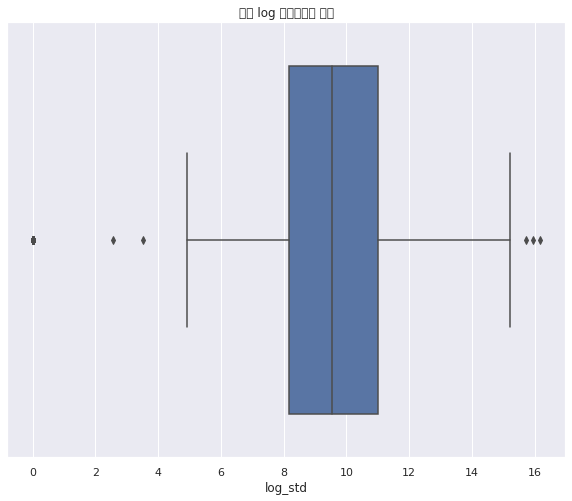

In [ ]:
# 상품 log 표준편차의 분포
plt.figure(figsize=(10,8))
sns.set_theme(style='darkgrid')
sns.boxplot(data=pd_price_std, x='log_std')
plt.title('상품 log 표준편차의 분포')
plt.show()

In [ ]:
# 상위 98% log_std 
q98=np.quantile(pd_price_std.log_std, 0.98)

# 상품 구분
## 특이 상품 : 1, 일반 상품 : 0
is_specials=pd_price_std.loc[pd_price_std.log_std >= q98].index
pd_price_std.loc[is_specials,'is_specials']=1
pd_price_std.fillna(0,inplace=True)
pd_price_std.head()

,pd_nm,std,log_std,is_specials
978,시계세트,10480033.74747,16.16498,1.00000
174,그림/인테리어렌탈,8339997.33546,15.93657,1.00000
385,남성시계,6838225.69659,15.73804,1.00000
466,냉장/냉동가전소모품,4109347.37096,15.22878,1.00000
1167,여성시계,3509786.16491,15.07107,1.00000


#### 특이 상품 구매 개수
- `특이 상품 구매 개수`와 `고객의 평소 소비 금액`의 관계가  '가성비 소비 행태', '사치 소비 행태' 등을 구분할 수 있을 것이라 판단

In [ ]:
# 고객별 상품 구매 개수
pd_price_std=pd_price_std[['pd_nm','is_specials']]
cust_item=train_interaction.groupby(['cust','pd_nm']).buy_ct.sum().reset_index()

#고객별 특이 상품 구매 개수
cust_item=pd.merge(cust_item,pd_price_std,how='inner',on='pd_nm')
cust_item['specials_cnt']=cust_item['buy_ct']*cust_item['is_specials']
cust_item.loc[cust_item.is_specials!=0].sample(10)

,cust,pd_nm,buy_ct,is_specials,specials_cnt
182884,M594460670,기타패션잡화,1,1.00000,1.00000
181169,M070050055,기타패션잡화,3,1.00000,3.00000
589985,M929586830,B01,2,1.00000,2.00000
589830,M861306547,B01,1,1.00000,1.00000
242467,M799767456,여성토트백,1,1.00000,1.00000
588515,M187568114,B01,3,1.00000,3.00000
1572238,M982739087,보석세트,1,1.00000,1.00000
589461,M665190770,B01,1,1.00000,1.00000
242384,M726403483,여성토트백,8,1.00000,8.00000
1561926,M440729575,스탠드형에어컨,2,1.00000,2.00000


#### feature 입력

In [ ]:
# 특이 상품 구매 개수의 합
cust_specials=cust_item.groupby(['cust']).specials_cnt.sum().reset_index()

# 병합
train_interaction=pd.merge(train_interaction,cust_specials,how='inner',on='cust')

display(cust_specials.head(),
        train_interaction.head())

,cust,specials_cnt
0,M000034966,0.00000
1,M000059535,0.00000
2,M000136117,16.00000
3,M000201112,0.00000
4,M000225114,0.00000


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,clac_hlv_nm,buy_am,buy_am_log,buy_am_mean_diff,buy_ct_mean_diff,buy_am_pct,buy_ct_pct,preference,re_buy_mean,specials_cnt
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류,15000.00000,9.61587,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,남성의류,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,1,0,...,테넌트/음식점,9900.00000,9.20039,9.19953,-0.61159,0.36309,0.18349,0.27329,0.00000,0.00000


### 5) featurn 8
- 엘페이 사용 여부와 정도

#### 고객별 엘페이 buy_am

In [ ]:
# 11월 15일 이전 lpay 사용 내역
lpay['de_dt']=lpay['de_dt'].astype(str)
lpay['de_dt']=pd.to_datetime(lpay['de_dt'])
lpay_split = lpay.loc[lpay.de_dt < "2021-11-15"]
lpay_split.head()

,cust,rct_no,cop_c,chnl_dv,de_dt,de_hr,buy_am
0,M629656521,210803210311226,A03,1,2021-08-03,21,10900
1,M216016456,210803130167542,L01,2,2021-08-03,13,6860
2,M205142844,210803140275112,A02,1,2021-08-03,14,9000
3,M737010483,210803040637594,A06,2,2021-08-03,4,36740
4,M707775545,210803140675502,A06,2,2021-08-03,14,138500


In [ ]:
# 고객 그룹 buy_am 합
lpay_cust_buy_am=lpay_split.groupby('cust').buy_am.sum().sort_values(ascending=False).reset_index()
lpay_cust_buy_am['log_buy_am']=lpay_cust_buy_am['buy_am'].apply(np.log1p)
lpay_cust_buy_am.head()

,cust,buy_am,log_buy_am
0,M619205727,633117779,20.26617
1,M890280911,155271698,18.86069
2,M561426592,124235520,18.63769
3,M384121563,108456961,18.50186
4,M268374518,87438340,18.28644


#### 엘페이 사용 금액 분포

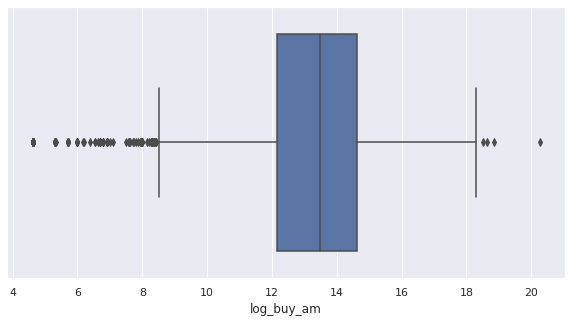

In [ ]:
fig, axs = plt.subplots(figsize = (10, 5))
sns.boxplot(data = lpay_cust_buy_am, x = "log_buy_am")

#### 엘페이 사용 금액 class
- `엘페이 사용 금액 상위 25% 이상` : 3
- `엘페이 사용 금액 상위 25% 미만 & 상위 75% 이상` : 2
- `엘페이 사용 금액 상위 75% 미만 & 상위 100% 이상` : 1
- `엘페이 사용 금액 0` : 0

In [ ]:
# 구분 금액
q_decending_25=np.quantile(lpay_cust_buy_am.log_buy_am, 0.75)
q_decending_75=np.quantile(lpay_cust_buy_am.log_buy_am, 0.25)
print(f'상위 25% log : {q_decending_25}, 원 단위 : {np.expm1(q_decending_25)}')
print(f'상위 75% log : {q_decending_75}, 원 단위 : {np.expm1(q_decending_75)}')

상위 25% log : 14.626797772836152, 원 단위 : 2250802.390371095
상위 75% log : 12.169413309830714, 원 단위 : 192799.8962660703


In [ ]:
def get_lpay_class(x):

  '''
  lpay_class 구분
  - 엘페이 사용 금액 log_buy_am 입력

  - 금액에 대한 class
    엘페이 사용 금액 상위 25% 이상 : 3
    엘페이 사용 금액 상위 25% 미만 & 상위 75% 이상 : 2
    엘페이 사용 금액 상위 75% 미만 & 상위 100% 이상 : 1
  '''

  if (x >= q_decending_25):
    return 3
  elif (x < q_decending_25) & (x >= q_decending_75):
    return 2
  elif (x < q_decending_75):
    return 1

In [ ]:
# 엘페이 사용 고객 class 입력
lpay_cust_buy_am['lpay_class']=lpay_cust_buy_am['log_buy_am'].apply(get_lpay_class)
lpay_cust_buy_am.sample(5)

,cust,buy_am,log_buy_am,lpay_class
5875,M216978877,303140,12.62195,2
7416,M628227277,94000,11.45106,1
2967,M896770606,1540710,14.24775,2
8288,M341129114,24250,10.09621,1
4695,M926571659,611140,13.32308,2


#### featurn 입력

In [ ]:
# 병합
lpay_cust_buy_am=lpay_cust_buy_am[['cust','lpay_class']]
train_interaction=pd.merge(train_interaction,lpay_cust_buy_am,how='left',on='cust')
print(train_interaction.isnull().sum())

# 엘페이 사용 금액 0 고객 : 0
train_interaction.fillna(0,inplace=True)

# 데이터 확인
lpay_cust_cnt=train_interaction.loc[train_interaction.lpay_class!=0]['cust'].nunique()
lpay_non_cust_cnt=train_interaction.loc[train_interaction.lpay_class==0]['cust'].nunique()
print(f'엘페이 이용 고객 수: {lpay_cust_cnt}')
print(f'엘페이 미이용 고객 수: {lpay_non_cust_cnt}')
train_interaction.head()

cust                      0
rct_no                    0
chnl_dv                   0
cop_c                     0
br_c                      0
pd_c                      0
de_dt                     0
de_hr                     0
buy_ct                    0
deal_type                 0
ma_fem_dv                 0
ages                      0
zon_hlv_user              0
zon_hlv                   0
zon_mcls                  0
pd_nm                     0
clac_mcls_nm              0
clac_hlv_nm               0
buy_am                    0
buy_am_log                0
buy_am_mean_diff          8
buy_ct_mean_diff          0
buy_am_pct                0
buy_ct_pct                0
preference                0
re_buy_mean               0
specials_cnt              0
lpay_class          2210281
dtype: int64
엘페이 이용 고객 수: 8779
엘페이 미이용 고객 수: 20683


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,buy_am,buy_am_log,buy_am_mean_diff,buy_ct_mean_diff,buy_am_pct,buy_ct_pct,preference,re_buy_mean,specials_cnt,lpay_class
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,15000.00000,9.61587,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,19000.00000,9.85225,9.79759,-0.77066,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,1,0,...,9900.00000,9.20039,9.19953,-0.61159,0.36309,0.18349,0.27329,0.00000,0.00000,0.00000


### 6) 기타 feature

#### 시간 변수 입력

In [ ]:
train_interaction['de_month']=train_interaction['de_dt'].dt.month
train_interaction['de_day']=train_interaction['de_dt'].dt.day
train_interaction['de_dow']=train_interaction['de_dt'].dt.weekday

#### 휴일, 공휴일 입력


In [ ]:
# 2021년 휴일, 공휴일 데이터
holiday = pd.read_csv("/content/mnt/MyDrive/LDA/data/holiday.csv")
display(holiday.head())
hday = set(holiday['날짜'].unique())

,이름,날짜,요일
0,신정,2021-01-01,4
1,설날,2021-02-11,3
2,설날,2021-02-12,4
3,설날,2021-02-13,5
4,삼일절,2021-03-01,0


In [ ]:
train_interaction['de_hday']=train_interaction['de_dow'].apply(lambda x : 1 if x == 5 or x == 6 else 0)
train_interaction.loc[train_interaction.de_dt.isin(hday),'de_hday'] = 1
train_interaction.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,buy_am_pct,buy_ct_pct,preference,re_buy_mean,specials_cnt,lpay_class,de_month,de_day,de_dow,de_hday
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,2.64067,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,1,0,...,0.36309,0.18349,0.27329,0.00000,0.00000,0.00000,1,1,4,1


#### 계절 정보 입력

In [ ]:
# 계절 정보 입력
def get_season(x):
  """
  계절에 따른 encoding 진행
  - 봄 : 0
  - 여름 : 1
  - 가을 : 2
  - 겨울 : 3
  """
  if x in [3, 4, 5]:
    return 0
  elif x in [6, 7, 8]:
    return 1
  elif x in [9, 10, 11]:
    return 2
  elif x in [12, 1, 2]:
    return 3

train_interaction['de_season']=train_interaction['de_month'].apply(get_season)
train_interaction.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,buy_ct_pct,preference,re_buy_mean,specials_cnt,lpay_class,de_month,de_day,de_dow,de_hday,de_season
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,0.73394,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,1,0,...,0.18349,0.27329,0.00000,0.00000,0.00000,1,1,4,1,3


#### 인구 이동 정보 입력

##### log scaling 적용

In [ ]:
mov_population = pd.read_csv("/content/mnt/MyDrive/LDA/(twelve_sum)population_all.csv")

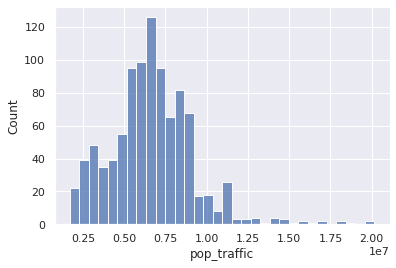

In [ ]:
sns.histplot(data = mov_population, x = "pop_traffic")

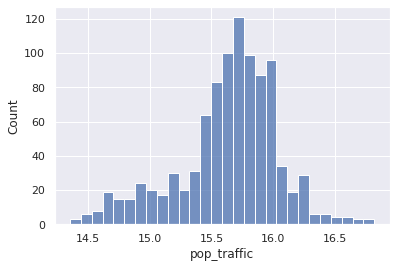

In [ ]:
mov_population['pop_traffic'] = mov_population['pop_traffic'].apply(np.log1p)
sns.histplot(data = mov_population, x = "pop_traffic")

In [ ]:
train_interaction=pd.merge(train_interaction,mov_population,how='left',on=['de_month','de_dow','ma_fem_dv','ages'])

display(mov_population.head(),
        train_interaction.head())

,de_month,de_dow,ma_fem_dv,ages,pop_traffic
0,1,0,남성,20대,15.33561
1,1,0,남성,30대,15.68737
2,1,0,남성,40대,15.85466
3,1,0,남성,50대,15.83650
4,1,0,남성,60대,15.49748


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,...,preference,re_buy_mean,specials_cnt,lpay_class,de_month,de_day,de_dow,de_hday,de_season,pop_traffic
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3,15.71663
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3,15.71663
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3,15.71663
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,1,0,...,1.68731,0.00000,0.00000,0.00000,1,1,4,1,3,15.71663
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,1,0,...,0.27329,0.00000,0.00000,0.00000,1,1,4,1,3,15.71663


### 7) 변수 사이 상관관계 확인

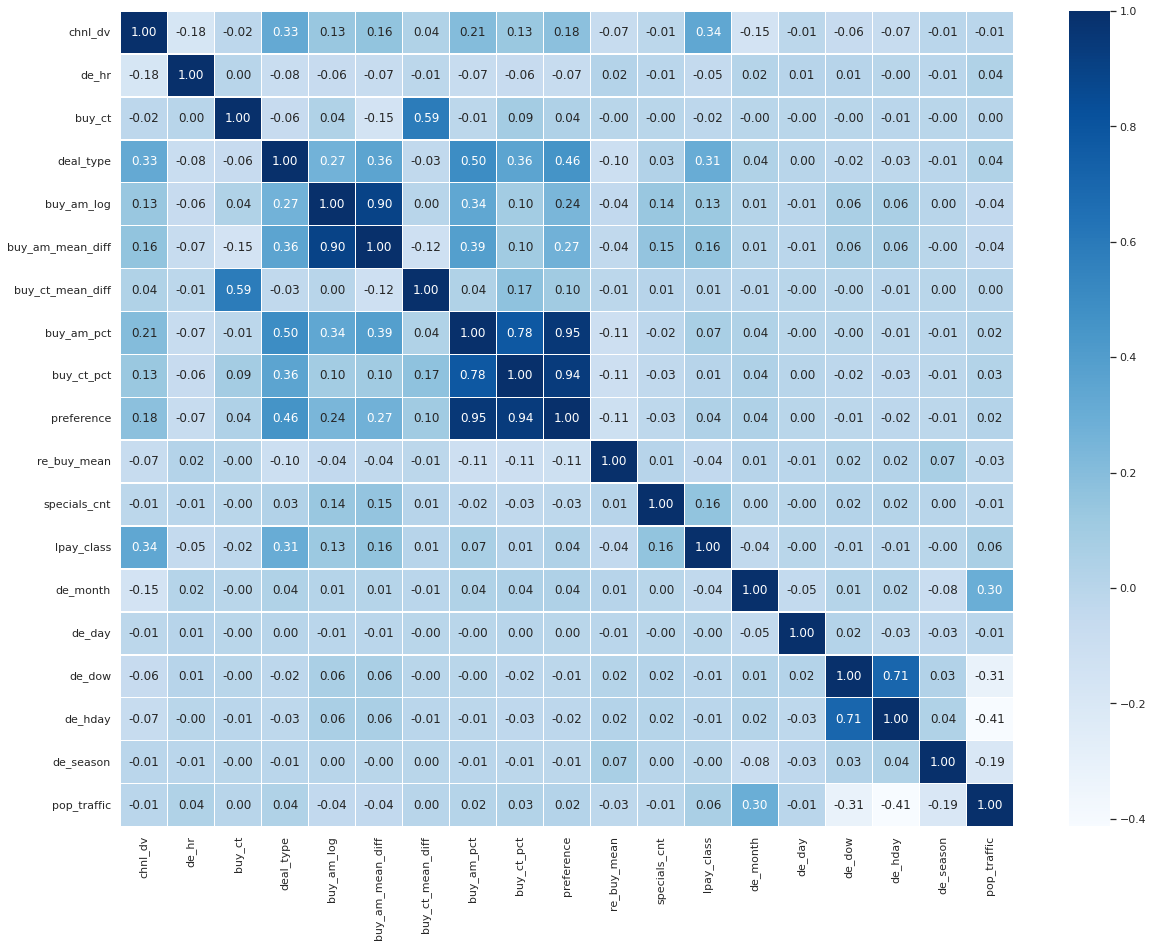

In [ ]:
fig, axs = plt.subplots(figsize = (20, 15))
sns.heatmap(data = train_interaction.drop(columns = ["buy_am"]).corr(), annot=True, fmt='.2f',linewidths=.5,cmap='Blues')

#### 시간 변수 인코딩

In [ ]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [ ]:
cyclical_features=['de_hr','de_month', 'de_day', 'de_dow', 'de_season']

for i in cyclical_features:
  train_interaction[i]=train_interaction[i].apply(float)
  train_interaction_encoded=encode(train_interaction, i, train_interaction[i].max())
  train_interaction_encoded.drop([i],axis=1,inplace=True)

train_interaction_encoded.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,buy_ct,deal_type,ma_fem_dv,...,de_hr_sin,de_hr_cos,de_month_sin,de_month_cos,de_day_sin,de_day_cos,de_dow_sin,de_dow_cos,de_season_sin,de_season_cos
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,1,0,여성,...,0.39840,-0.91721,0.50000,0.86603,0.20130,0.97953,-0.86603,-0.50000,-0.00000,1.00000
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,1,0,여성,...,0.39840,-0.91721,0.50000,0.86603,0.20130,0.97953,-0.86603,-0.50000,-0.00000,1.00000
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,1,0,여성,...,0.39840,-0.91721,0.50000,0.86603,0.20130,0.97953,-0.86603,-0.50000,-0.00000,1.00000
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,1,0,여성,...,0.39840,-0.91721,0.50000,0.86603,0.20130,0.97953,-0.86603,-0.50000,-0.00000,1.00000
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,1,0,여성,...,0.39840,-0.91721,0.50000,0.86603,0.20130,0.97953,-0.86603,-0.50000,-0.00000,1.00000


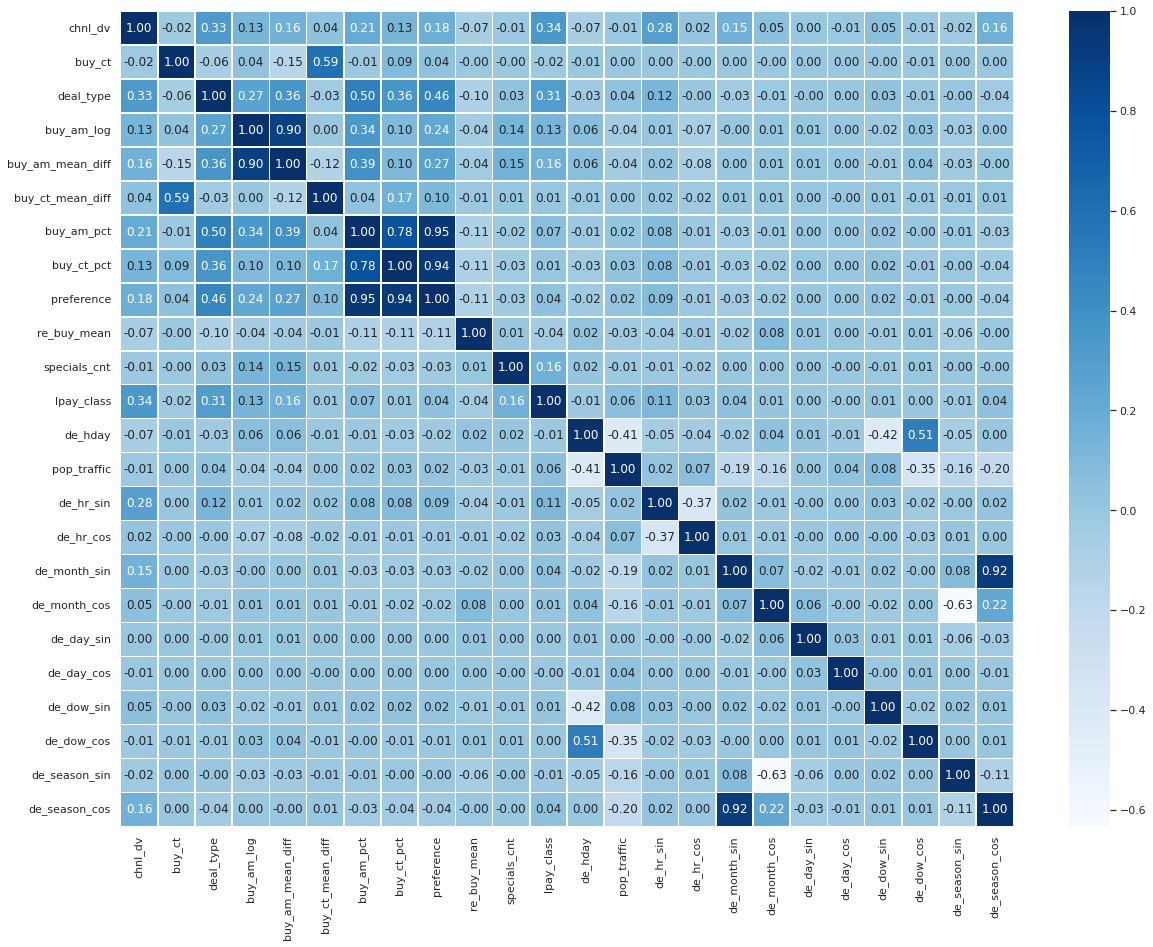

In [ ]:
fig, axs = plt.subplots(figsize = (20, 15))
sns.heatmap(data = train_interaction.drop(columns = ["buy_am"]).corr(), annot=True, fmt='.2f',linewidths=.5,cmap='Blues')

## C. 사용할 특성 추출

- `유저` 특성
  - `특이 상품 구매 개수`, `lpay 사용 정도`
- `유저 - 상품` 특성
  - `pd_c`에 대한 `선호도`, `재구매 주기 평균`, `구매 횟수`

In [ ]:
user_feats = train_interaction.groupby(["cust", "specials_cnt", "lpay_class"])['rct_no'].count().reset_index()
user_feats.drop(columns = ['rct_no'], inplace = True)
user_feats.to_csv("/content/mnt/MyDrive/LDA/data/user_feats.csv", index = False)

In [ ]:
user_item_feats = train_interaction[["cust", "pd_c", "preference", "re_buy_mean", "buy_ct_pct"]]
user_item_feats = user_item_feats.drop_duplicates()
user_item_feats = user_item_feats.sort_values(by = ["cust", "pd_c"])
user_item_feats.to_csv("/content/mnt/MyDrive/LDA/data/user_item_feats.csv", index = False)

In [ ]:
interaction.to_csv("/content/mnt/MyDrive/LDA/data/interaction_scaled.csv", index = False)

# TabNet을 통한 가격 예측

## A.TabNet 패키지 설치
- 사전 훈련된 임베딩을 활용하기 위해서 수정한 패키지

In [ ]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [ ]:
!git clone https://github.com/Woodywarhol9/tabnet

Cloning into 'tabnet'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070
Receiving objects: 100% (1070/1070), 6.34 MiB | 19.85 MiB/s, done.
Resolving deltas: 100% (698/698), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
if os.getcwd() != "/content/tabnet":
  os.chdir("tabnet")

# CUDA ERROR 확인
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
interaction = pd.read_csv("/content/mnt/MyDrive/LDA/data/interaction_scaled.csv")

user_feats = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_feats.csv")
user_item_feats = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_item_feats.csv")
# SDM을 통해 얻은 Embedding
user_emb_64 = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_emb_64.csv")
user_emb_64_wo_price = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_emb_64_wo_price.csv")

user_emb_32 = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_emb_32.csv")
user_emb_32_wo_price = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_emb_32_wo_price.csv")

holiday = pd.read_csv("/content/mnt/MyDrive/LDA/data/holiday.csv")
mov_population = pd.read_csv("/content/mnt/MyDrive/LDA/(twelve_sum)population_all.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### 변수 추가

In [ ]:
# 계절 정보 입력
def get_season(x):
  """
  계절에 따른 encoding 진행
  - 봄 : 0
  - 여름 : 1
  - 가을 : 2
  - 겨울 : 3
  """
  if x in [3, 4, 5]:
    return 0
  elif x in [6, 7, 8]:
    return 1
  elif x in [9, 10, 11]:
    return 2
  elif x in [12, 1, 2]:
    return 3

In [ ]:
interaction.drop(columns = ["rct_no", "pd_nm"], inplace = True)
interaction['de_dt'] = interaction['de_dt'].astype("str")
interaction['de_dt'] = pd.to_datetime(interaction['de_dt'])

interaction['de_month'] = interaction['de_dt'].dt.month
interaction['de_day'] = interaction['de_dt'].dt.day
interaction['de_dow'] = interaction['de_dt'].dt.weekday
interaction['de_hday'] = interaction['de_dt'].apply

hday = set(holiday['날짜'].unique())
interaction['de_hday'] = interaction['de_dow'].apply(lambda x : 1 if x == 5 or x == 6 else 0)
interaction.loc[interaction.de_dt.isin(hday),'de_hday'] = 1
interaction['de_season']=interaction['de_month'].apply(get_season)
mov_population['pop_traffic'] = mov_population['pop_traffic'].apply(np.log1p)
interaction=pd.merge(interaction,mov_population,how='left',on=['de_month','de_dow','ma_fem_dv','ages'])

interaction = interaction.loc[interaction.de_dt >= "20211115"]
interaction = interaction.sort_values(["cust", "pd_c"])
interaction

,cust,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,ma_fem_dv,...,clac_mcls_nm,clac_hlv_nm,buy_am,buy_am_log,de_month,de_day,de_dow,de_hday,de_season,pop_traffic
3023033,M000034966,1,A02,A020116,PD0218,2021-12-23,19,1,0,여성,...,비스킷류,과자,1980.0,7.591357,12,23,3,0,3,15.966770
3023028,M000034966,1,A02,A020116,PD0228,2021-12-23,19,1,0,여성,...,스낵류,과자,2380.0,7.775276,12,23,3,0,3,15.966770
3023032,M000034966,1,A02,A020116,PD0228,2021-12-23,19,1,0,여성,...,스낵류,과자,1980.0,7.591357,12,23,3,0,3,15.966770
3023029,M000034966,1,A02,A020116,PD0232,2021-12-23,19,1,0,여성,...,스낵류,과자,1980.0,7.591357,12,23,3,0,3,15.966770
3023030,M000034966,1,A02,A020116,PD0232,2021-12-23,19,1,0,여성,...,스낵류,과자,1200.0,7.090910,12,23,3,0,3,15.966770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516861,M999962961,1,D01,D010884,PD1937,2021-12-16,17,1,1,여성,...,F&B,제휴사,1900.0,7.550135,12,16,3,0,3,16.014359
4516862,M999962961,1,D01,D010884,PD1937,2021-12-16,17,1,1,여성,...,F&B,제휴사,14000.0,9.546884,12,16,3,0,3,16.014359
4516866,M999962961,1,D01,D010884,PD1937,2021-12-23,17,1,1,여성,...,F&B,제휴사,5900.0,8.682877,12,23,3,0,3,16.014359
4650168,M999962961,1,A01,A019999,PD1942,2021-12-16,17,1,2,여성,...,A01,유통사,159600.0,11.980432,12,16,3,0,3,16.014359


## B. 활용할 임베딩 값만 추출

In [ ]:
def get_emb(emb, interaction):
  user_emb = emb.loc[emb.cust.isin(interaction.cust)]
  user_emb = user_emb.reset_index().drop(columns = ["index"])
  return user_emb

In [ ]:
user_emb_64 = get_emb(user_emb_64, interaction)
user_emb_64_wo_price = get_emb(user_emb_64_wo_price, interaction)

user_emb_32 = get_emb(user_emb_32, interaction)
user_emb_32_wo_price = get_emb(user_emb_32_wo_price, interaction)

###  결측치 처리 : 선호도를 미리 알 수 없기 때문에 0으로 설정

In [ ]:
temp = interaction.groupby(["cust", "pd_c"])['chnl_dv'].count().reset_index().drop(columns = ["chnl_dv"], axis = 1)
temp = temp.merge(user_item_feats, how = "inner")
temp

,cust,pd_c,preference,re_buy_mean,buy_ct_pct
0,M000034966,PD0218,1.259863,0.000000,1.818182
1,M000136117,PD0298,1.788098,0.000000,3.478261
2,M000136117,PD0900,1.732559,59.000000,2.608696
3,M000136117,PD1827,3.715852,79.000000,2.608696
4,M000136117,PD1937,6.063584,20.909091,11.304348
...,...,...,...,...,...
196497,M999962961,PD1839,0.522243,152.000000,0.731707
196498,M999962961,PD1919,9.886698,25.666667,18.048780
196499,M999962961,PD1935,1.121862,15.250000,1.219512
196500,M999962961,PD1937,0.456457,91.500000,0.731707


In [ ]:
interaction = interaction.merge(temp, how = "left")
interaction.loc[interaction.preference.isnull(), 'preference'] = 0
interaction.loc[interaction.re_buy_mean.isnull(), "re_buy_mean"] = 0
interaction.loc[interaction.buy_ct_pct.isnull(), "buy_ct_pct"] = 0
interaction = interaction.merge(user_feats, how = "left")
interaction.loc[interaction.specials_cnt.isnull(), "specials_cnt"] = 0
interaction.loc[interaction.lpay_class.isnull(), "lpay_class"] = 0
interaction.head(5)

,cust,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_ct,deal_type,ma_fem_dv,...,de_day,de_dow,de_hday,de_season,pop_traffic,preference,re_buy_mean,buy_ct_pct,specials_cnt,lpay_class
0,M000034966,1,A02,A020116,PD0218,2021-12-23,19,1,0,여성,...,23,3,0,3,15.96677,1.259863,0.0,1.818182,0.0,0.0
1,M000034966,1,A02,A020116,PD0228,2021-12-23,19,1,0,여성,...,23,3,0,3,15.96677,0.000000,0.0,0.000000,0.0,0.0
2,M000034966,1,A02,A020116,PD0228,2021-12-23,19,1,0,여성,...,23,3,0,3,15.96677,0.000000,0.0,0.000000,0.0,0.0
3,M000034966,1,A02,A020116,PD0232,2021-12-23,19,1,0,여성,...,23,3,0,3,15.96677,0.000000,0.0,0.000000,0.0,0.0
4,M000034966,1,A02,A020116,PD0232,2021-12-23,19,1,0,여성,...,23,3,0,3,15.96677,0.000000,0.0,0.000000,0.0,0.0


### BUY_AM 로그 스케일링

In [ ]:
interaction['buy_am_log']= interaction['buy_am'].apply(np.log1p)
interaction.drop(columns = ["buy_am"], inplace = True)

## C. 인코딩 진행

In [ ]:
interaction.dtypes

cust                    object
chnl_dv                  int64
cop_c                   object
br_c                    object
pd_c                    object
de_dt           datetime64[ns]
de_hr                    int64
buy_ct                   int64
deal_type                int64
ma_fem_dv               object
ages                    object
zon_hlv_user            object
zon_hlv                 object
zon_mcls                object
clac_mcls_nm            object
clac_hlv_nm             object
buy_am_log             float64
de_month                 int64
de_day                   int64
de_dow                   int64
de_hday                  int64
de_season                int64
pop_traffic            float64
preference             float64
re_buy_mean            float64
buy_ct_pct             float64
specials_cnt           float64
lpay_class             float64
dtype: object

In [ ]:
interaction.isnull().sum()

cust            0
chnl_dv         0
cop_c           0
br_c            0
pd_c            0
de_dt           0
de_hr           0
buy_ct          0
deal_type       0
ma_fem_dv       0
ages            0
zon_hlv_user    0
zon_hlv         0
zon_mcls        0
clac_mcls_nm    0
clac_hlv_nm     0
buy_am_log      0
de_month        0
de_day          0
de_dow          0
de_hday         0
de_season       0
pop_traffic     0
preference      0
re_buy_mean     0
buy_ct_pct      0
specials_cnt    0
lpay_class      0
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

def cat_encoding(data, cat_list, emb):
  """
  카테고리로 처리할 컬럼 리스트를 인코딩합니다.
  """
  cat_columns = []
  cat_dims = []
  cat_encoders = {}
  for col in data.columns[data.columns.isin(cat_list)]:
    print(col, data[col].nunique())
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col].values)

    cat_columns.append(col)
    cat_dims.append(len(encoder.classes_))
    cat_encoders[col] = encoder
  cat_emb_dims = [len(emb.loc[0]) - 1] * len(cat_columns)
  
  return cat_columns, cat_dims, cat_encoders, cat_emb_dims

cat_list = ["cust", "chnl_dv", "cop_c", "br_c", "pd_c", "de_hr", "deal_type", "ma_fem_dv", "ages", "zon_hlv_user", "zon_hlv", "zon_mcls", "clac_mcls_nm", "clac_hlv_nm", "lpay_class", "de_month", "de_day", "de_dow", "de_hday", "de_season"]

cat_columns, cat_dims, cat_encoders, cat_emb_dims = cat_encoding(interaction, cat_list, user_emb_64)
print("TabNet Embedding dims : ", end = "")
print(*zip(cat_columns, cat_emb_dims))

cust 22759
chnl_dv 2
cop_c 14
br_c 5418
pd_c 1713
de_hr 24
deal_type 3
ma_fem_dv 2
ages 6
zon_hlv_user 17
zon_hlv 19
zon_mcls 250
clac_mcls_nm 347
clac_hlv_nm 61
de_month 2
de_day 31
de_dow 7
de_hday 2
de_season 2
lpay_class 4
TabNet Embedding dims : ('cust', 64) ('chnl_dv', 64) ('cop_c', 64) ('br_c', 64) ('pd_c', 64) ('de_hr', 64) ('deal_type', 64) ('ma_fem_dv', 64) ('ages', 64) ('zon_hlv_user', 64) ('zon_hlv', 64) ('zon_mcls', 64) ('clac_mcls_nm', 64) ('clac_hlv_nm', 64) ('de_month', 64) ('de_day', 64) ('de_dow', 64) ('de_hday', 64) ('de_season', 64) ('lpay_class', 64)


## D. 훈련/평가 데이터 정의

In [ ]:
target = "buy_am_log"
feats = [col for col in interaction.columns if col not in [target, "de_dt"]]
print(f"Feats : {feats}")
cat_idxs = [ i for i, f in enumerate(feats) if f in cat_columns]

train = interaction.loc[(interaction.de_dt >= "2021-11-15") & (interaction.de_dt < "2021-12-15")].reset_index().drop(columns = ["index"])
valid = interaction.loc[(interaction.de_dt >= "2021-12-15") & (interaction.de_dt < "2021-12-19")].reset_index().drop(columns = ["index"])
test = interaction.loc[(interaction.de_dt >= "2021-12-19") & (interaction.de_dt < "2021-12-23")].reset_index().drop(columns = ["index"])

train.drop(columns = ["de_dt"], inplace = True)
valid.drop(columns = ["de_dt"], inplace = True)
test.drop(columns = ["de_dt"], inplace = True)

Feats : ['cust', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_hr', 'buy_ct', 'deal_type', 'ma_fem_dv', 'ages', 'zon_hlv_user', 'zon_hlv', 'zon_mcls', 'clac_mcls_nm', 'clac_hlv_nm', 'de_month', 'de_day', 'de_dow', 'de_hday', 'de_season', 'pop_traffic', 'preference', 're_buy_mean', 'buy_ct_pct', 'specials_cnt', 'lpay_class']


In [ ]:
"""
train_label = train[["cust", "buy_am_log"]]
valid_label = valid[["cust", "buy_am_log"]]
test_label = test[["cust", "buy_am_log"]]

train_label['cust'] = cat_encoders['cust'].inverse_transform(train_label['cust'])
valid_label['cust'] = cat_encoders['cust'].inverse_transform(valid_label['cust'])
test_label['cust'] = cat_encoders['cust'].inverse_transform(test_label['cust'])

train_label.to_csv("/content/mnt/MyDrive/LDA/data/train_label.csv", index = False)
valid_label.to_csv("/content/mnt/MyDrive/LDA/data/valid_label.csv", index = False)
test_label.to_csv("/content/mnt/MyDrive/LDA/data/test_label.csv", index = False)
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
train.columns

Index(['cust', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_hr', 'buy_ct',
       'deal_type', 'ma_fem_dv', 'ages', 'zon_hlv_user', 'zon_hlv', 'zon_mcls',
       'clac_mcls_nm', 'clac_hlv_nm', 'buy_am_log', 'de_month', 'de_day',
       'de_dow', 'de_hday', 'de_season', 'pop_traffic', 'preference',
       're_buy_mean', 'buy_ct_pct', 'specials_cnt', 'lpay_class'],
      dtype='object')

In [ ]:
from sklearn.utils import shuffle

train = shuffle(train, random_state=42)

x_train, y_train = train.drop(columns = [target]), train[target]
x_valid, y_valid = valid.drop(columns = [target]), valid[target]
x_test, y_test = test.drop(columns = [target]), test[target]

x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함
x_valid, y_valid = np.array(x_valid), np.array(y_valid).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함
x_test, y_test = np.array(x_test), np.array(y_test).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함

In [ ]:
from pytorch_tabnet.augmentations import RegressionSMOTE

aug = RegressionSMOTE(p=0.3)

args = {
    "n_steps" : 3,
    "max_epochs" : 100,
    "patience" : 10,
    "batch_size" :2 ** 14,
    "virtual_batch_size" : 512,
    "num_workers" : 0,
    "drop_last" : False,
    "augmentations" : aug
    }
user_emb = user_emb_64

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

clf = TabNetRegressor(n_steps = args['n_steps'], cat_dims=cat_dims, cat_emb_dim=cat_emb_dims, cat_idxs=cat_idxs, pretrained_embed=np.array(user_emb.drop(columns = ['cust'])))

/content/tabnet/pytorch_tabnet/abstract_model.py:76: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
train.cust.nunique()

20163

In [ ]:
user_emb

,cust,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,M000034966,-0.121070,-0.062030,-0.015647,0.032578,-0.014015,-0.000852,0.024420,0.001338,0.005392,...,0.023706,-0.003718,0.191494,-0.040410,-0.095292,-0.028855,0.068207,0.077863,-0.007420,-0.055064
1,M000136117,-0.000953,-0.038075,-0.190898,-0.046859,0.259060,-0.011161,0.257341,-0.008735,-0.014675,...,0.178364,-0.025407,-0.222288,-0.022259,-0.036384,-0.228755,-0.468037,-0.028282,-0.047153,0.034636
2,M000201112,-0.000191,-0.005522,0.076736,0.019532,0.162435,-0.000765,-0.123342,0.030111,0.243223,...,-0.266457,0.000244,-0.071724,0.067874,-0.044137,-0.062469,-0.018685,-0.013637,-0.000396,-0.002651
3,M000225114,-0.001410,-0.007409,-0.162857,0.172728,-0.181073,-0.004588,-0.025422,0.019590,-0.034528,...,-0.296283,-0.032646,-0.178274,0.014006,0.017919,0.157569,0.122902,-0.228083,-0.006965,-0.002914
4,M000261625,0.003598,-0.050148,-0.171653,-0.117089,0.257862,-0.001355,-0.005594,0.099225,0.179117,...,0.094506,-0.005701,-0.364898,-0.176869,0.000413,-0.089182,-0.360815,0.035718,-0.020547,0.008506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22754,M999673157,0.083336,-0.011749,-0.326381,-0.341114,0.054089,0.006553,0.174238,0.222485,-0.183943,...,0.170639,-0.034696,0.001944,-0.036359,0.015724,-0.330927,-0.084799,-0.008077,0.004386,-0.010388
22755,M999770689,-0.002608,-0.001353,-0.081119,-0.342794,0.145987,0.282207,0.008826,0.044097,-0.130964,...,-0.124238,-0.004659,-0.075740,-0.017217,-0.033713,-0.105139,-0.084569,-0.075923,-0.006563,0.010825
22756,M999849895,-0.130971,-0.074382,0.007979,0.091663,0.008797,0.151002,-0.016255,0.012969,-0.007160,...,-0.005431,-0.031331,0.069318,-0.016614,0.160956,-0.004405,-0.011461,0.018088,0.000731,-0.260226
22757,M999926092,-0.182395,0.072516,0.036700,0.024990,-0.000970,-0.074264,0.000530,0.004784,-0.006163,...,0.007188,0.038886,-0.076357,0.024462,-0.218405,-0.026134,-0.012604,-0.003772,-0.182013,-0.234364


In [ ]:
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train),(x_valid, y_valid)], # 검증 입력 가능
    eval_name=['train', "valid"],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=args['max_epochs'],
    patience=args['patience'],
    batch_size=args['batch_size'], virtual_batch_size=args['virtual_batch_size'],
    num_workers=args['num_workers'],
    drop_last=False,
    augmentations=args['augmentations'],
)

epoch 0  | loss: 15.76184| train_rmsle: 0.04076 | train_mae: 1.472   | train_rmse: 2.22465 | train_mse: 4.94905 | valid_rmsle: 0.0349  | valid_mae: 1.35973 | valid_rmse: 2.00409 | valid_mse: 4.01638 |  0:00:22s
epoch 1  | loss: 1.58911 | train_rmsle: 0.01664 | train_mae: 0.93902 | train_rmse: 1.26729 | train_mse: 1.60603 | valid_rmsle: 0.01591 | valid_mae: 0.92025 | valid_rmse: 1.23644 | valid_mse: 1.5288  |  0:00:42s
epoch 2  | loss: 1.20946 | train_rmsle: 0.01255 | train_mae: 0.79784 | train_rmse: 1.09358 | train_mse: 1.19592 | valid_rmsle: 0.01211 | valid_mae: 0.7857  | valid_rmse: 1.0716  | valid_mse: 1.14833 |  0:01:01s
epoch 3  | loss: 1.04178 | train_rmsle: 0.01071 | train_mae: 0.73448 | train_rmse: 0.99616 | train_mse: 0.99233 | valid_rmsle: 0.01032 | valid_mae: 0.72501 | valid_rmse: 0.97632 | valid_mse: 0.95319 |  0:01:20s
epoch 4  | loss: 0.96491 | train_rmsle: 0.01017 | train_mae: 0.72285 | train_rmse: 0.97508 | train_mse: 0.95078 | valid_rmsle: 0.00969 | valid_mae: 0.70798 

/content/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## E.결과 확인

#### Feature Importance 확인

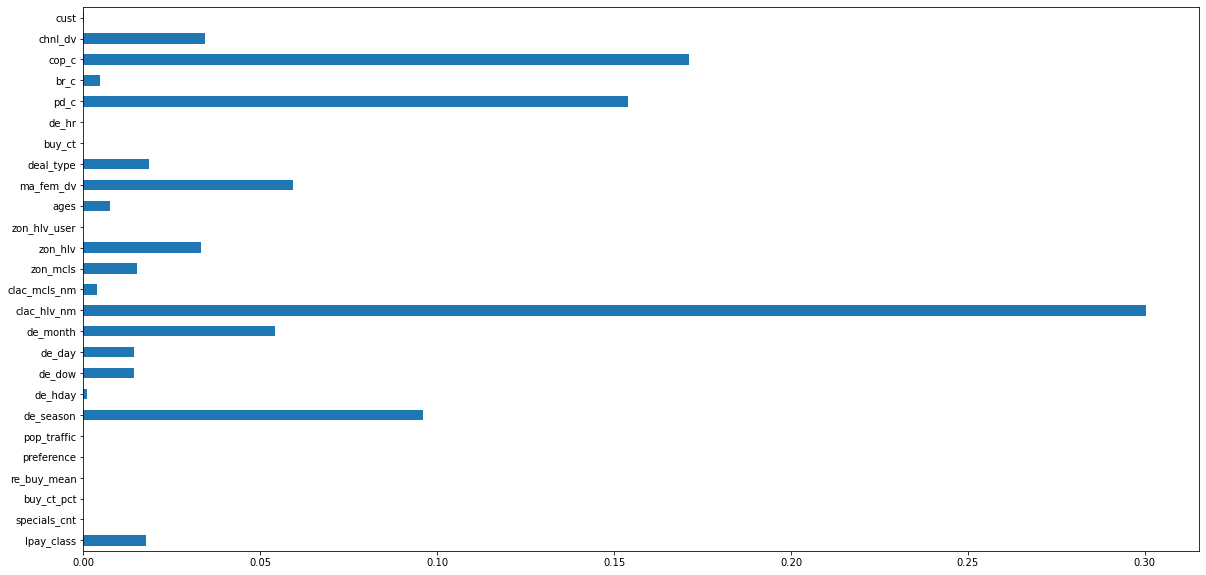

In [ ]:
# global
fig, axs = plt.subplots(figsize = (20, 10))
feat_importances = pd.Series(clf.feature_importances_[::-1], index=feats[::-1])
feat_importances.plot(kind='barh')

#### Feature Mask 확인

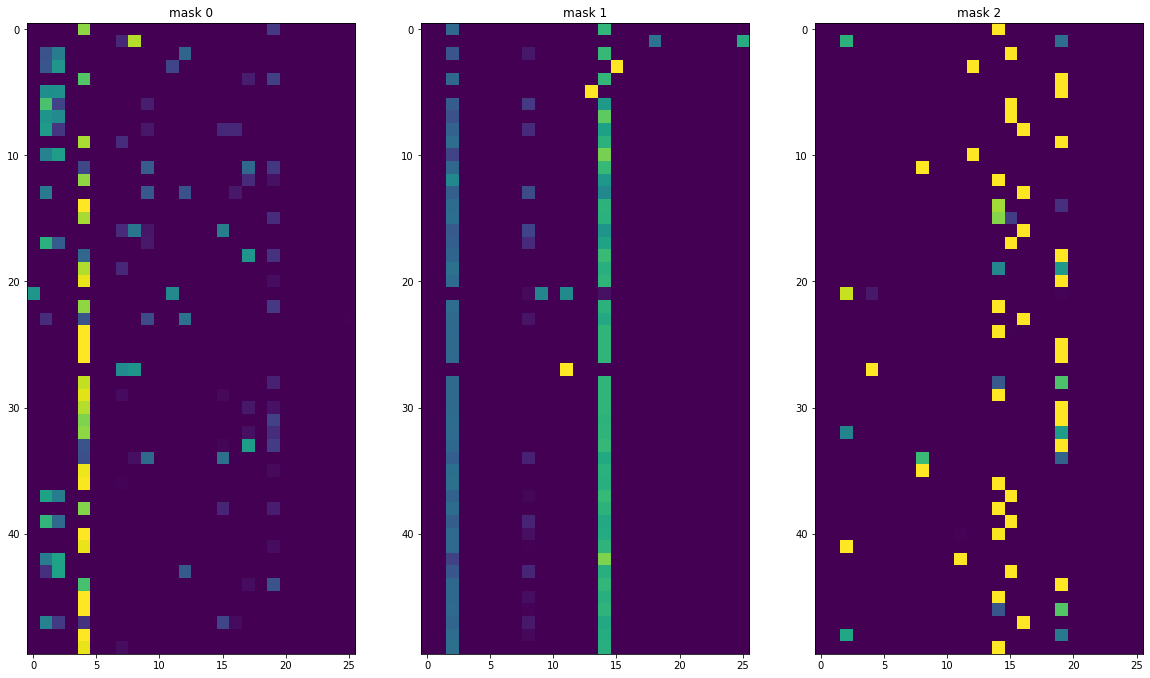

In [ ]:
explain_matrix, masks = clf.explain(x_train)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

#### 예측 오차 확인

- 로그 예측 값 기준
  

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_train)
print(f"MSE(LOG) : {mean_squared_error(preds, y_train)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_train)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_train)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_train))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_train))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_train))}")

train['preds'] = preds

MSE(LOG) : 0.39442049776759425
RMSE(LOG) : 0.7607949116103375
MAE(LOG) : 0.43692270198228655
______________________________________________________________________
MSE : 16148791552.500715
RMSE : 127077.89560934945
MAE : 13405.69890627159


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_valid)
print(f"MSE(LOG) : {mean_squared_error(preds, y_valid)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_valid)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_valid)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_valid))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_valid))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_valid))}")

valid['preds'] = preds

MSE(LOG) : 0.4244172934628477
RMSE(LOG) : 0.7451396337261393
MAE(LOG) : 0.4591723087420864
______________________________________________________________________
MSE : 5930373958.907202
RMSE : 77008.92129427084
MAE : 11825.932025208462


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_test)
print(f"MSE(LOG) : {mean_squared_error(preds, y_test)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_test)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_test)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_test))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_test))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_test))}")

test['preds'] = preds

MSE(LOG) : 0.4513554321395403
RMSE(LOG) : 0.7313554064744696
MAE(LOG) : 0.46740132453766314
______________________________________________________________________
MSE : 10396902474.53331
RMSE : 101965.20227280143
MAE : 13000.957189691015


#### 결과 저장

In [ ]:
saving_path_name = "/content/mnt/MyDrive/LDA/3. LDA_ 데이터 및 모델 세이브 파일/2) 모델 세이브 파일/tabnet.pt"
torch.save(clf.network.state_dict(), saving_path_name)

In [ ]:
model = torch.load('model.pth')

In [ ]:
def inverse_transform(data, encoders):
  for i in encoders:
    data[i] = encoders[i].inverse_transform(data[i])
  
  return data

In [ ]:
train = inverse_transform(train, cat_encoders)
valid = inverse_transform(valid, cat_encoders)
test = inverse_transform(test, cat_encoders)

seed = 42

In [ ]:
t

,cust,chnl_dv,cop_c,br_c,pd_c,de_hr,buy_ct,deal_type,ma_fem_dv,ages,...,de_dow,de_hday,de_season,pop_traffic,preference,re_buy_mean,buy_ct_pct,specials_cnt,lpay_class,preds
30231,M088494538,1,A04,A042409,PD1154,17,1,0,여성,50대,...,1,0,3,15.781355,0.451585,105.500000,0.534188,0.0,0.0,7.610321
59290,M172572397,1,C01,C010003,PD1935,20,1,1,여성,40대,...,4,0,3,15.968231,2.828867,89.000000,4.629630,1.0,2.0,8.608593
43433,M125559492,2,C01,C010000,PD1935,15,1,1,여성,20대,...,2,0,2,15.777323,11.732266,27.666667,10.000000,1.0,0.0,9.214079
25010,M072055624,2,A06,A069999,PD1947,13,1,2,여성,30대,...,0,0,3,15.664044,29.264678,3.776316,11.177052,3.0,3.0,10.854334
224260,M663528966,1,A02,A020063,PD1160,19,1,0,여성,50대,...,1,0,3,15.781355,1.724320,40.500000,2.122642,4.0,0.0,8.653358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,M347493616,1,A03,A030236,PD0322,11,1,0,여성,20대,...,6,1,2,15.617232,0.000000,0.000000,0.000000,0.0,0.0,8.881582
259178,M766838439,1,A01,A010028,PD1340,12,1,0,여성,40대,...,1,0,2,15.979312,0.000000,0.000000,0.000000,5.0,2.0,9.699868
131932,M380362011,1,A01,A010049,PD0780,17,1,0,남성,20대,...,2,0,2,15.628813,1.845268,0.000000,1.020408,0.0,0.0,10.993897
146867,M425728822,1,D02,D020363,PD1938,17,1,1,여성,30대,...,3,0,3,15.954446,13.268784,15.315789,18.750000,4.0,2.0,8.600294


In [ ]:
train.to_csv(f"/content/mnt/MyDrive/LDA/data/train-64-{seed}.csv", index = False)
valid.to_csv(f"/content/mnt/MyDrive/LDA/data/valid-64-{seed}.csv", index = False)
test.to_csv(f"/content/mnt/MyDrive/LDA/data/test-64-{seed}.csv", index = False)

---

## F. 임베딩 입력에 따른 예측 결과 비교

### 64_wo_price
- 가격 정보를 포함하지 않은 임베딩을 입력한 경우

In [ ]:
cat_emb_dims = [len(user_emb_64.loc[0]) - 1] * len(cat_columns)
print("TabNet Embedding dims : ", end = "")
print(*zip(cat_columns, cat_emb_dims))

TabNet Embedding dims : ('cust', 64) ('chnl_dv', 64) ('cop_c', 64) ('br_c', 64) ('pd_c', 64) ('de_hr', 64) ('deal_type', 64) ('ma_fem_dv', 64) ('ages', 64) ('zon_hlv_user', 64) ('zon_hlv', 64) ('zon_mcls', 64) ('clac_mcls_nm', 64) ('clac_hlv_nm', 64) ('de_month', 64) ('de_day', 64) ('de_dow', 64) ('de_hday', 64) ('de_season', 64) ('lpay_class', 64)


In [ ]:
target = "buy_am_log"
feats = [col for col in interaction.columns if col not in [target, "de_dt"]]
print(f"Feats : {feats}")
cat_idxs = [ i for i, f in enumerate(feats) if f in cat_columns]

train = interaction.loc[(interaction.de_dt >= "2021-11-15") & (interaction.de_dt < "2021-12-15")].reset_index().drop(columns = ["index"])
valid = interaction.loc[(interaction.de_dt >= "2021-12-15") & (interaction.de_dt < "2021-12-19")].reset_index().drop(columns = ["index"])
test = interaction.loc[(interaction.de_dt >= "2021-12-19") & (interaction.de_dt < "2021-12-23")].reset_index().drop(columns = ["index"])

train.drop(columns = ["de_dt"], inplace = True)
valid.drop(columns = ["de_dt"], inplace = True)
test.drop(columns = ["de_dt"], inplace = True)

Feats : ['cust', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_hr', 'buy_ct', 'deal_type', 'ma_fem_dv', 'ages', 'zon_hlv_user', 'zon_hlv', 'zon_mcls', 'clac_mcls_nm', 'clac_hlv_nm', 'de_month', 'de_day', 'de_dow', 'de_hday', 'de_season', 'pop_traffic', 'preference', 're_buy_mean', 'buy_ct_pct', 'specials_cnt', 'lpay_class']


In [ ]:
from sklearn.utils import shuffle

train = shuffle(train, random_state=42)

x_train, y_train = train.drop(columns = [target]), train[target]
x_valid, y_valid = valid.drop(columns = [target]), valid[target]
x_test, y_test = test.drop(columns = [target]), test[target]

x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함
x_valid, y_valid = np.array(x_valid), np.array(y_valid).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함
x_test, y_test = np.array(x_test), np.array(y_test).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함

In [ ]:
from pytorch_tabnet.augmentations import RegressionSMOTE

aug = RegressionSMOTE(p=0.3)

args = {
    "n_steps" : 3,
    "max_epochs" : 100,
    "patience" : 10,
    "batch_size" :2 ** 14,
    "virtual_batch_size" : 512,
    "num_workers" : 0,
    "drop_last" : False,
    "augmentations" : aug
    }
user_emb = user_emb_64_wo_price

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

clf = TabNetRegressor(n_steps = args['n_steps'], cat_dims=cat_dims, cat_emb_dim=cat_emb_dims, cat_idxs=cat_idxs, pretrained_embed=np.array(user_emb.drop(columns = ['cust'])))

/content/tabnet/pytorch_tabnet/abstract_model.py:76: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train),(x_valid, y_valid)], # 검증 입력 가능
    eval_name=['train', "valid"],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=args['max_epochs'],
    patience=args['patience'],
    batch_size=args['batch_size'], virtual_batch_size=args['virtual_batch_size'],
    num_workers=args['num_workers'],
    drop_last=False,
    augmentations=args['augmentations'],
)

epoch 0  | loss: 15.84159| train_rmsle: 0.04064 | train_mae: 1.49924 | train_rmse: 1.94532 | train_mse: 3.78427 | valid_rmsle: 0.03977 | valid_mae: 1.47165 | valid_rmse: 1.91529 | valid_mse: 3.66835 |  0:00:19s
epoch 1  | loss: 1.64417 | train_rmsle: 0.01765 | train_mae: 0.97386 | train_rmse: 1.30882 | train_mse: 1.71302 | valid_rmsle: 0.01541 | valid_mae: 0.91427 | valid_rmse: 1.20965 | valid_mse: 1.46325 |  0:00:38s
epoch 2  | loss: 1.34876 | train_rmsle: 0.01502 | train_mae: 0.89242 | train_rmse: 1.196   | train_mse: 1.43042 | valid_rmsle: 0.01441 | valid_mae: 0.87984 | valid_rmse: 1.16363 | valid_mse: 1.35404 |  0:00:57s
epoch 3  | loss: 1.262   | train_rmsle: 0.01682 | train_mae: 0.92504 | train_rmse: 1.28794 | train_mse: 1.65879 | valid_rmsle: 0.01992 | valid_mae: 0.99463 | valid_rmse: 1.42637 | valid_mse: 2.03453 |  0:01:16s
epoch 4  | loss: 1.19981 | train_rmsle: 0.01277 | train_mae: 0.81348 | train_rmse: 1.08619 | train_mse: 1.17981 | valid_rmsle: 0.01236 | valid_mae: 0.8007  

/content/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


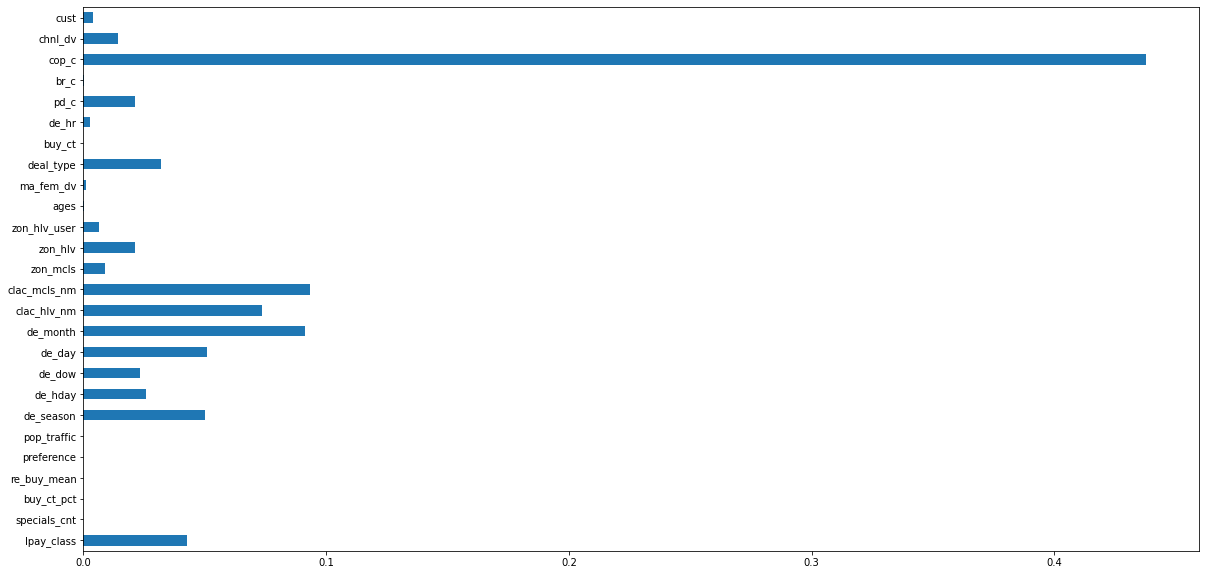

In [ ]:
# global
fig, axs = plt.subplots(figsize = (20, 10))
feat_importances = pd.Series(clf.feature_importances_[::-1], index=feats[::-1])
feat_importances.plot(kind='barh')

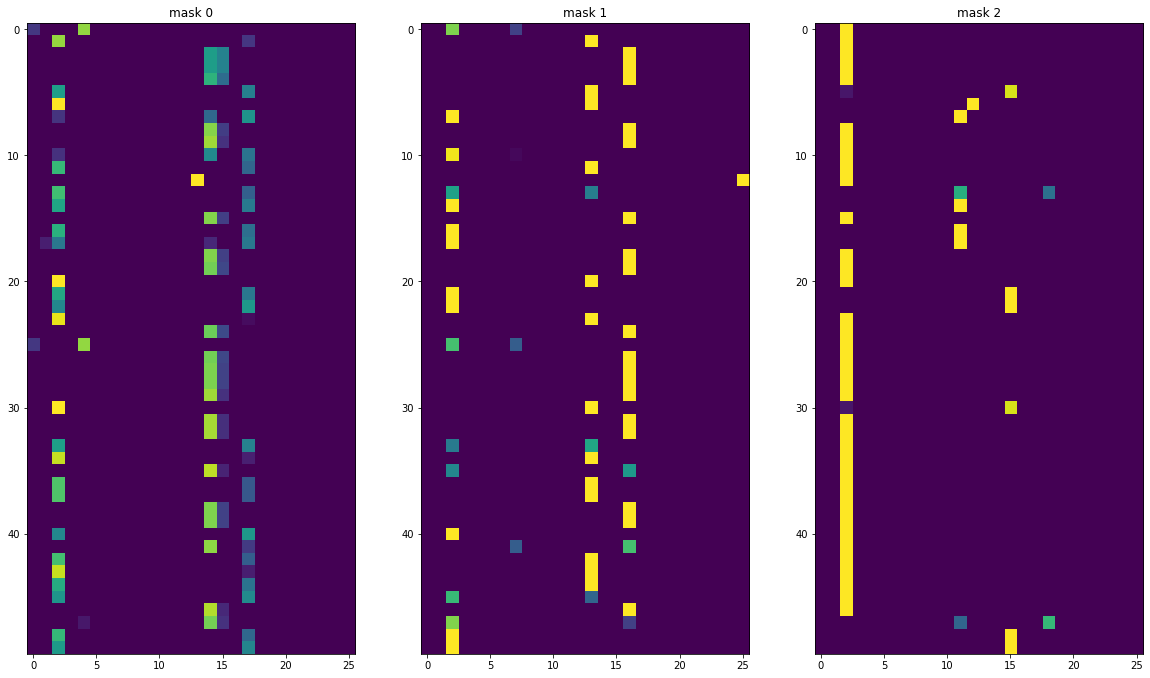

In [ ]:
explain_matrix, masks = clf.explain(x_test)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_train)
print(f"MSE(LOG) : {mean_squared_error(preds, y_train)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_train)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_train)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_train))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_train))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_train))}")

train['preds'] = preds

MSE(LOG) : 0.46060654238613896
RMSE(LOG) : 0.7266806810514829
MAE(LOG) : 0.4781713254068392
______________________________________________________________________
MSE : 16542033272.089006
RMSE : 128615.83600820316
MAE : 14191.17654850336


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_valid)
print(f"MSE(LOG) : {mean_squared_error(preds, y_valid)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_valid)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_valid)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_valid))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_valid))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_valid))}")

valid['preds'] = preds

MSE(LOG) : 0.46631648866116904
RMSE(LOG) : 0.7238102841769593
MAE(LOG) : 0.48120443327966084
______________________________________________________________________
MSE : 5980650528.715061
RMSE : 77334.6657632595
MAE : 12167.425706460079


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_test)
print(f"MSE(LOG) : {mean_squared_error(preds, y_test)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_test)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_test)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_test))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_test))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_test))}")

test['preds'] = preds

MSE(LOG) : 0.48468456492872547
RMSE(LOG) : 0.7146533066830112
MAE(LOG) : 0.48906645565998597
______________________________________________________________________
MSE : 10575486788.101068
RMSE : 102837.18582351944
MAE : 13296.67410843994


In [ ]:
def inverse_transform(data, encoders):
  for i in encoders:
    data[i] = encoders[i].inverse_transform(data[i])
  
  return data

In [ ]:
train = inverse_transform(train, cat_encoders)
valid = inverse_transform(valid, cat_encoders)
test = inverse_transform(test, cat_encoders)

seed = 42

In [ ]:
train.to_csv(f"/content/mnt/MyDrive/LDA/data/train-64-wo_price-{seed}.csv", index = False)
valid.to_csv(f"/content/mnt/MyDrive/LDA/data/valid-64-wo_price-{seed}.csv", index = False)
test.to_csv(f"/content/mnt/MyDrive/LDA/data/test-64-wo_price-{seed}.csv", index = False)

### 64_wo_pretrain
- 사전 학습된 임베딩을 활용하지 않은 경우

In [ ]:
cat_emb_dims = [len(user_emb_64.loc[0]) - 1] * len(cat_columns)
print("TabNet Embedding dims : ", end = "")
print(*zip(cat_columns, cat_emb_dims))

TabNet Embedding dims : ('cust', 64) ('chnl_dv', 64) ('cop_c', 64) ('br_c', 64) ('pd_c', 64) ('de_hr', 64) ('deal_type', 64) ('ma_fem_dv', 64) ('ages', 64) ('zon_hlv_user', 64) ('zon_hlv', 64) ('zon_mcls', 64) ('clac_mcls_nm', 64) ('clac_hlv_nm', 64) ('de_month', 64) ('de_day', 64) ('de_dow', 64) ('de_hday', 64) ('de_season', 64) ('lpay_class', 64)


In [ ]:
target = "buy_am_log"
feats = [col for col in interaction.columns if col not in [target, "de_dt"]]
print(f"Feats : {feats}")
cat_idxs = [ i for i, f in enumerate(feats) if f in cat_columns]

train = interaction.loc[(interaction.de_dt >= "2021-11-15") & (interaction.de_dt < "2021-12-15")].reset_index().drop(columns = ["index"])
valid = interaction.loc[(interaction.de_dt >= "2021-12-15") & (interaction.de_dt < "2021-12-19")].reset_index().drop(columns = ["index"])
test = interaction.loc[(interaction.de_dt >= "2021-12-19") & (interaction.de_dt < "2021-12-23")].reset_index().drop(columns = ["index"])

train.drop(columns = ["de_dt"], inplace = True)
valid.drop(columns = ["de_dt"], inplace = True)
test.drop(columns = ["de_dt"], inplace = True)

Feats : ['cust', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_hr', 'buy_ct', 'deal_type', 'ma_fem_dv', 'ages', 'zon_hlv_user', 'zon_hlv', 'zon_mcls', 'clac_mcls_nm', 'clac_hlv_nm', 'de_month', 'de_day', 'de_dow', 'de_hday', 'de_season', 'pop_traffic', 'preference', 're_buy_mean', 'buy_ct_pct', 'specials_cnt', 'lpay_class']


In [ ]:
from sklearn.utils import shuffle

train = shuffle(train, random_state=42)

x_train, y_train = train.drop(columns = [target]), train[target]
x_valid, y_valid = valid.drop(columns = [target]), valid[target]
x_test, y_test = test.drop(columns = [target]), test[target]

x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함
x_valid, y_valid = np.array(x_valid), np.array(y_valid).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함
x_test, y_test = np.array(x_test), np.array(y_test).reshape(-1, 1) # tabnet 입력 형태 Y 는 2차원으로 맞춰야 함

In [ ]:
from pytorch_tabnet.augmentations import RegressionSMOTE

aug = RegressionSMOTE(p=0.3)

args = {
    "n_steps" : 3,
    "max_epochs" : 100,
    "patience" : 10,
    "batch_size" :2 ** 14,
    "virtual_batch_size" : 512,
    "num_workers" : 0,
    "drop_last" : False,
    "augmentations" : aug
    }

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

clf = TabNetRegressor(n_steps = args['n_steps'], cat_dims=cat_dims, cat_emb_dim=cat_emb_dims, cat_idxs=cat_idxs)

/content/tabnet/pytorch_tabnet/abstract_model.py:76: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train),(x_valid, y_valid)], # 검증 입력 가능
    eval_name=['train', "valid"],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=args['max_epochs'],
    patience=args['patience'],
    batch_size=args['batch_size'], virtual_batch_size=args['virtual_batch_size'],
    num_workers=args['num_workers'],
    drop_last=False,
    augmentations=args['augmentations'],
)

epoch 0  | loss: 30.20249| train_rmsle: 0.05554 | train_mae: 1.94012 | train_rmse: 2.43407 | train_mse: 5.92467 | valid_rmsle: 0.05468 | valid_mae: 1.88165 | valid_rmse: 2.38378 | valid_mse: 5.68241 |  0:00:19s
epoch 1  | loss: 1.99743 | train_rmsle: 0.01978 | train_mae: 1.04325 | train_rmse: 1.37193 | train_mse: 1.88218 | valid_rmsle: 0.01859 | valid_mae: 1.00363 | valid_rmse: 1.33621 | valid_mse: 1.78545 |  0:00:37s
epoch 2  | loss: 1.29333 | train_rmsle: 0.01408 | train_mae: 0.86266 | train_rmse: 1.14861 | train_mse: 1.3193  | valid_rmsle: 0.01369 | valid_mae: 0.8551  | valid_rmse: 1.12898 | valid_mse: 1.2746  |  0:00:56s
epoch 3  | loss: 1.07371 | train_rmsle: 0.01286 | train_mae: 0.82522 | train_rmse: 1.09828 | train_mse: 1.20621 | valid_rmsle: 0.01238 | valid_mae: 0.8273  | valid_rmse: 1.07416 | valid_mse: 1.15381 |  0:01:15s
epoch 4  | loss: 0.91219 | train_rmsle: 0.01084 | train_mae: 0.75221 | train_rmse: 0.99915 | train_mse: 0.99831 | valid_rmsle: 0.00983 | valid_mae: 0.70559 

/content/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


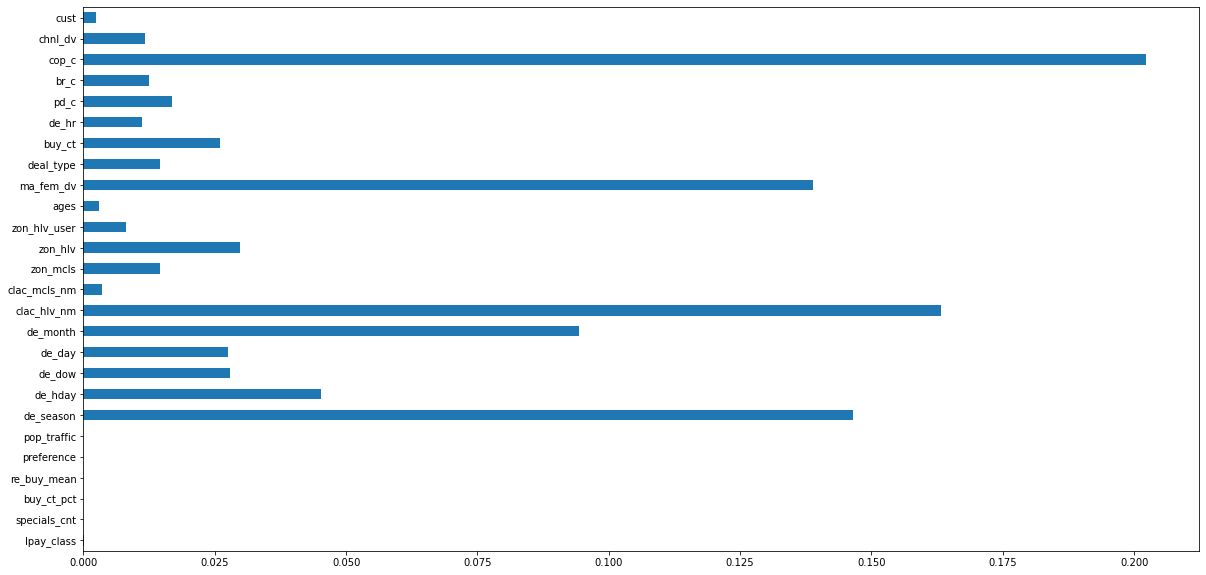

In [ ]:
# global
fig, axs = plt.subplots(figsize = (20, 10))
feat_importances = pd.Series(clf.feature_importances_[::-1], index=feats[::-1])
feat_importances.plot(kind='barh')

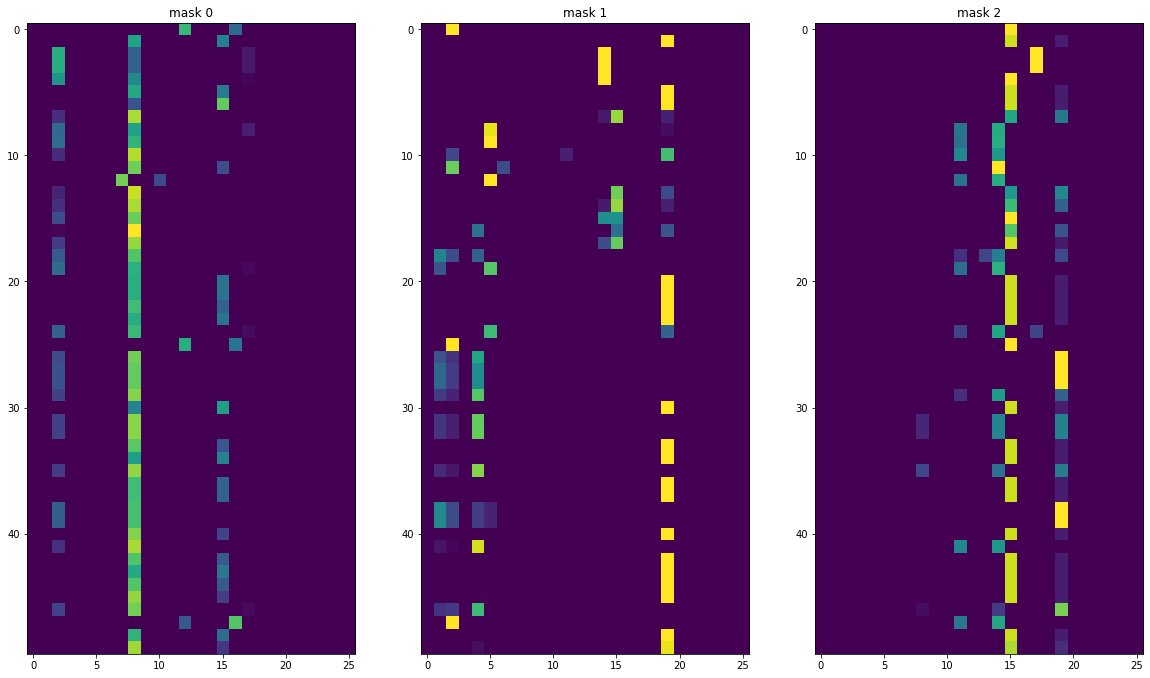

In [ ]:
explain_matrix, masks = clf.explain(x_test)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_train)
print(f"MSE(LOG) : {mean_squared_error(preds, y_train)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_train)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_train)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_train))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_train))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_train))}")

train['preds'] = preds

MSE(LOG) : 0.3734089115774903
RMSE(LOG) : 0.7719563019463138
MAE(LOG) : 0.4384691471619359
______________________________________________________________________
MSE : 14955648339.557344
RMSE : 122293.2882032262
MAE : 12265.6959392242


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_valid)
print(f"MSE(LOG) : {mean_squared_error(preds, y_valid)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_valid)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_valid)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_valid))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_valid))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_valid))}")

valid['preds'] = preds

MSE(LOG) : 0.48852986762527456
RMSE(LOG) : 0.7127510340766775
MAE(LOG) : 0.49832288930683544
______________________________________________________________________
MSE : 6984102723.209553
RMSE : 83570.9442522313
MAE : 12504.142425057813


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


preds = clf.predict(x_test)
print(f"MSE(LOG) : {mean_squared_error(preds, y_test)}")
print(f"RMSE(LOG) : {0.5 ** mean_squared_error(preds, y_test)}")
print(f"MAE(LOG) : {mean_absolute_error(preds, y_test)}")
print("______________________________________________________________________")
print(f"MSE : {mean_squared_error(np.expm1(preds), np.expm1(y_test))}")
print(f"RMSE : {(mean_squared_error(np.expm1(preds), np.expm1(y_test))) ** 0.5}")
print(f"MAE : {mean_absolute_error(np.expm1(preds), np.expm1(y_test))}")

test['preds'] = preds

MSE(LOG) : 0.5201169170142834
RMSE(LOG) : 0.6973153199644777
MAE(LOG) : 0.5093655581389126
______________________________________________________________________
MSE : 12243939898.361084
RMSE : 110652.33797060541
MAE : 14592.697183810604


In [ ]:
def inverse_transform(data, encoders):
  for i in encoders:
    data[i] = encoders[i].inverse_transform(data[i])
  
  return data

In [ ]:
train = inverse_transform(train, cat_encoders)
valid = inverse_transform(valid, cat_encoders)
test = inverse_transform(test, cat_encoders)

seed = 42

In [ ]:
train.to_csv(f"/content/mnt/MyDrive/LDA/data/train-64-wo_pretrain-{seed}.csv", index = False)
valid.to_csv(f"/content/mnt/MyDrive/LDA/data/valid-64-wo_pretrain-{seed}.csv", index = False)
test.to_csv(f"/content/mnt/MyDrive/LDA/data/test-64-wo_pretrain-{seed}.csv", index = False)